# 0.0 IMPORTS

In [1]:
import math
import datetime
import pandas as pd
import inflection
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy import stats as ss
from IPython.display import Image
from IPython.core.display import HTML

from boruta import BorutaPy
from xgboost import XGBRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1 Helper Functions

In [184]:
def show_nas(df):
    result = pd.DataFrame({
        'type': df.dtypes,
        'NA': df.isna().sum(),
        'NA%': round( ( df.isna().sum() / len(df1) ) * 100, 2 )
    })
    return result.sort_values('NA%', ascending=False)    

def mean_absolute_percentage_error(y, yhat):
    return np.mean( np.abs( (y - yhat) / y ) )
    
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name' : model_name,
                            'MAE' : mae, 
                            'MAPE': mape,
                            'RMSE': rmse }, index = [0] )

def cramer_v( attr1, attr2 ):
    cm = pd.crosstab( attr1, attr2 ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]

    chi2corr = max(0, chi2 - ( k - 1 ) * ( r - 1 ) / ( n - 1 ) )
    kcorr = k - ( k - 1 )**2 / ( n - 1)
    rcorr = r - ( r - 1 )**2 / ( n - 1)
    
    return np.sqrt( ( chi2corr / n ) / ( min( kcorr - 1, rcorr - 1 ) ) )

def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    
    k = 1
    
    for k in reversed( range ( 1, kfold+1 ) ):
        
        if verbose:
            print( 'KFold Number: {}'.format ( k ))
        
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7 )
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7 )
        
        # filtering dataset
        training = x_training[ x_training['date'] < validation_start_date ]
        validation = x_training[ ( x_training['date'] >= validation_start_date ) & ( x_training['date'] <= validation_end_date ) ]
        
        # training and validation dataset
        
        # training
        ytraining = training['sales']
        xtraining = training.drop( ['date', 'sales'], axis = 1 )
        
        # validation
        yvalidation = validation['sales']
        xvalidation = validation.drop( ['date', 'sales'], axis = 1 )
        
        # model
        m = model.fit( xtraining, ytraining )
        
        # prediction
        yhat = m.predict( xvalidation )
        
        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1 ( yhat ) )
        
        # store performance of each kfold iteration
        mae_list.append( m_result[ 'MAE' ] )
        mape_list.append( m_result[ 'MAPE' ] )
        rmse_list.append( m_result[ 'RMSE' ] )
    
    return pd.DataFrame( { 'Model name' : model_name,
                          'MAE CV' : np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV' : np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV' : np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )

def jupyter_settings(): 
    %matplotlib inline 
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') ) 
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/developer/.pyenv/versions/3.9.16/envs/DataScienceEmProducao/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['grid']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2 Loading Data

In [3]:
df_sales_raw = pd.read_csv('data/rossmann_store_sales/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/rossmann_store_sales/store.csv', low_memory=False)

# Merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')
df_raw.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
94178,519,5,2015-05-08,5894,595,1,1,0,0,c,c,2510.0,8.0,2009.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
639057,948,5,2013-12-06,9311,2231,1,1,0,0,b,b,1430.0,NaN,NaN,0,NaN,NaN,NaN
866103,534,4,2013-05-16,7611,566,1,1,0,0,d,a,1200.0,9.0,2009.0,1,45.0,2009.0,"Jan,Apr,Jul,Oct"
277450,1033,2,2014-11-18,11982,1208,1,0,0,0,a,a,7680.0,3.0,2006.0,0,NaN,NaN,NaN
925667,1003,7,2013-03-24,0,0,0,0,0,0,a,a,170.0,7.0,2013.0,1,27.0,2013.0,"Jan,Apr,Jul,Oct"


In [4]:
df_store_raw.shape

(1115, 10)

# 1.0 PASSO 01 - DESCRIÇAO DOS DADOS

In [5]:
df1 = df_raw.copy()

##  1.1 Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# Rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [7]:
print('Number of rows: ', df1.shape[0])
print('Number of cols: ', df1.shape[1])

Number of rows:  1017209
Number of cols:  18


## 1.3 Data Types

In [8]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NAs

In [9]:
show_nas(df1)

,type,NA,NA%
promo_interval,object,508031,49.94
promo2_since_year,float64,508031,49.94
promo2_since_week,float64,508031,49.94
competition_open_since_year,float64,323348,31.79
competition_open_since_month,float64,323348,31.79
competition_distance,float64,2642,0.26
day_of_week,int64,0,0.00
promo2,int64,0,0.00
assortment,object,0,0.00
store,int64,0,0.00


## 1.5 Fillout NAs

In [10]:
df1['competition_distance'].max()

75860.0

In [11]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(
    lambda x: 200000.0 
    if math.isnan( x ) 
    else x )

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply( 
    lambda x: x['date'].month 
    if math.isnan( x['competition_open_since_month'] ) 
    else x['competition_open_since_month'], 
    axis=1 )

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply( 
    lambda x: x['date'].year 
    if math.isnan( x['competition_open_since_year'] ) 
    else x['competition_open_since_year'], 
    axis=1 )

# promo2_since_week
df1['promo2_since_week'] = df1.apply( 
    lambda x: x['date'].week 
    if math.isnan( x['promo2_since_week'] ) 
    else x['promo2_since_week'], 
    axis=1 )

# promo2_since_year
df1['promo2_since_year'] = df1.apply( 
    lambda x: x['date'].year 
    if math.isnan( x['promo2_since_year'] ) 
    else x['promo2_since_year'], 
    axis=1 )

In [12]:
# promo_interval
month_map = {
    1 : 'Jan',
    2 : 'Fev',
    3 : 'Mar',
    4 : 'Apr',
    5 : 'May',
    6 : 'Jun',
    7 : 'Jul',
    8 : 'Aug',
    9 : 'Sep',
    10 : 'Oct',
    11 : 'Nov',
    12 : 'Dec',
}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
    lambda x: 0 
    if x['promo_interval'] == 0 
    else 1 
    if x['month_map'] in x['promo_interval'].split( ',' ) 
    else 0, 
    axis=1 )

In [13]:
show_nas(df1)

,type,NA,NA%
store,int64,0,0.0
day_of_week,int64,0,0.0
month_map,object,0,0.0
promo_interval,object,0,0.0
promo2_since_year,float64,0,0.0
promo2_since_week,float64,0,0.0
promo2,int64,0,0.0
competition_open_since_year,float64,0,0.0
competition_open_since_month,float64,0,0.0
competition_distance,float64,0,0.0


## 1.6 Change Types

In [14]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [15]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical

In [46]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

state_holiday
0    986159
a     20260
b      6690
c      4100
Name: count, dtype: int64

### 1.7.1 Numerial Attributes

In [18]:
df1.describe().T

,count,mean,min,25%,50%,75%,max,std
store,1017209.0,558.429727,1.0,280.0,558.0,838.0,1115.0,321.908651
day_of_week,1017209.0,3.998341,1.0,2.0,4.0,6.0,7.0,1.997391
date,1017209,2014-04-11 01:30:42.846061824,2013-01-01 00:00:00,2013-08-17 00:00:00,2014-04-02 00:00:00,2014-12-12 00:00:00,2015-07-31 00:00:00,NaN
sales,1017209.0,5773.818972,0.0,3727.0,5744.0,7856.0,41551.0,3849.926175
customers,1017209.0,633.145946,0.0,405.0,609.0,837.0,7388.0,464.411734
open,1017209.0,0.830107,0.0,1.0,1.0,1.0,1.0,0.375539
promo,1017209.0,0.381515,0.0,0.0,0.0,1.0,1.0,0.485759
school_holiday,1017209.0,0.178647,0.0,0.0,0.0,0.0,1.0,0.383056
competition_distance,1017209.0,5935.442677,20.0,710.0,2330.0,6910.0,200000.0,12547.652996
competition_open_since_month,1017209.0,6.786849,1.0,4.0,7.0,10.0,12.0,3.311087


In [19]:
pd.DataFrame({
    'Skew': num_attributes.apply( lambda x: x.skew()).tolist(),
    'kutosis': num_attributes.apply( lambda x: x.kurtosis()) .tolist()
}, index = num_attributes.columns.tolist())

,Skew,kutosis
store,-0.000955,-1.200524
day_of_week,0.001593,-1.246873
sales,0.641460,1.778375
customers,1.598650,7.091773
open,-1.758045,1.090723
promo,0.487838,-1.762018
school_holiday,1.677842,0.815154
competition_distance,10.242344,147.789712
competition_open_since_month,-0.042076,-1.232607
competition_open_since_year,-7.235657,124.071304


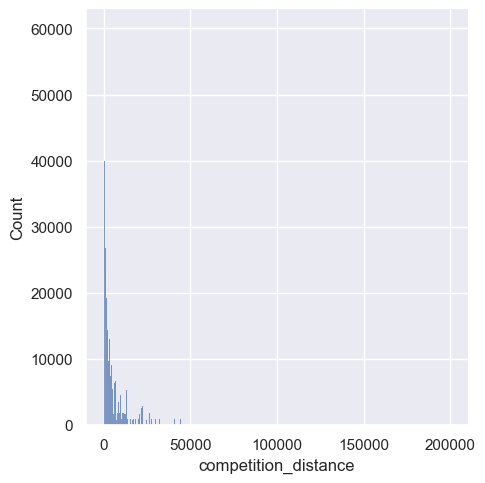

In [21]:
sns.displot( df1['competition_distance'] );

### 1.7.2 Categorical Attributes

In [22]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

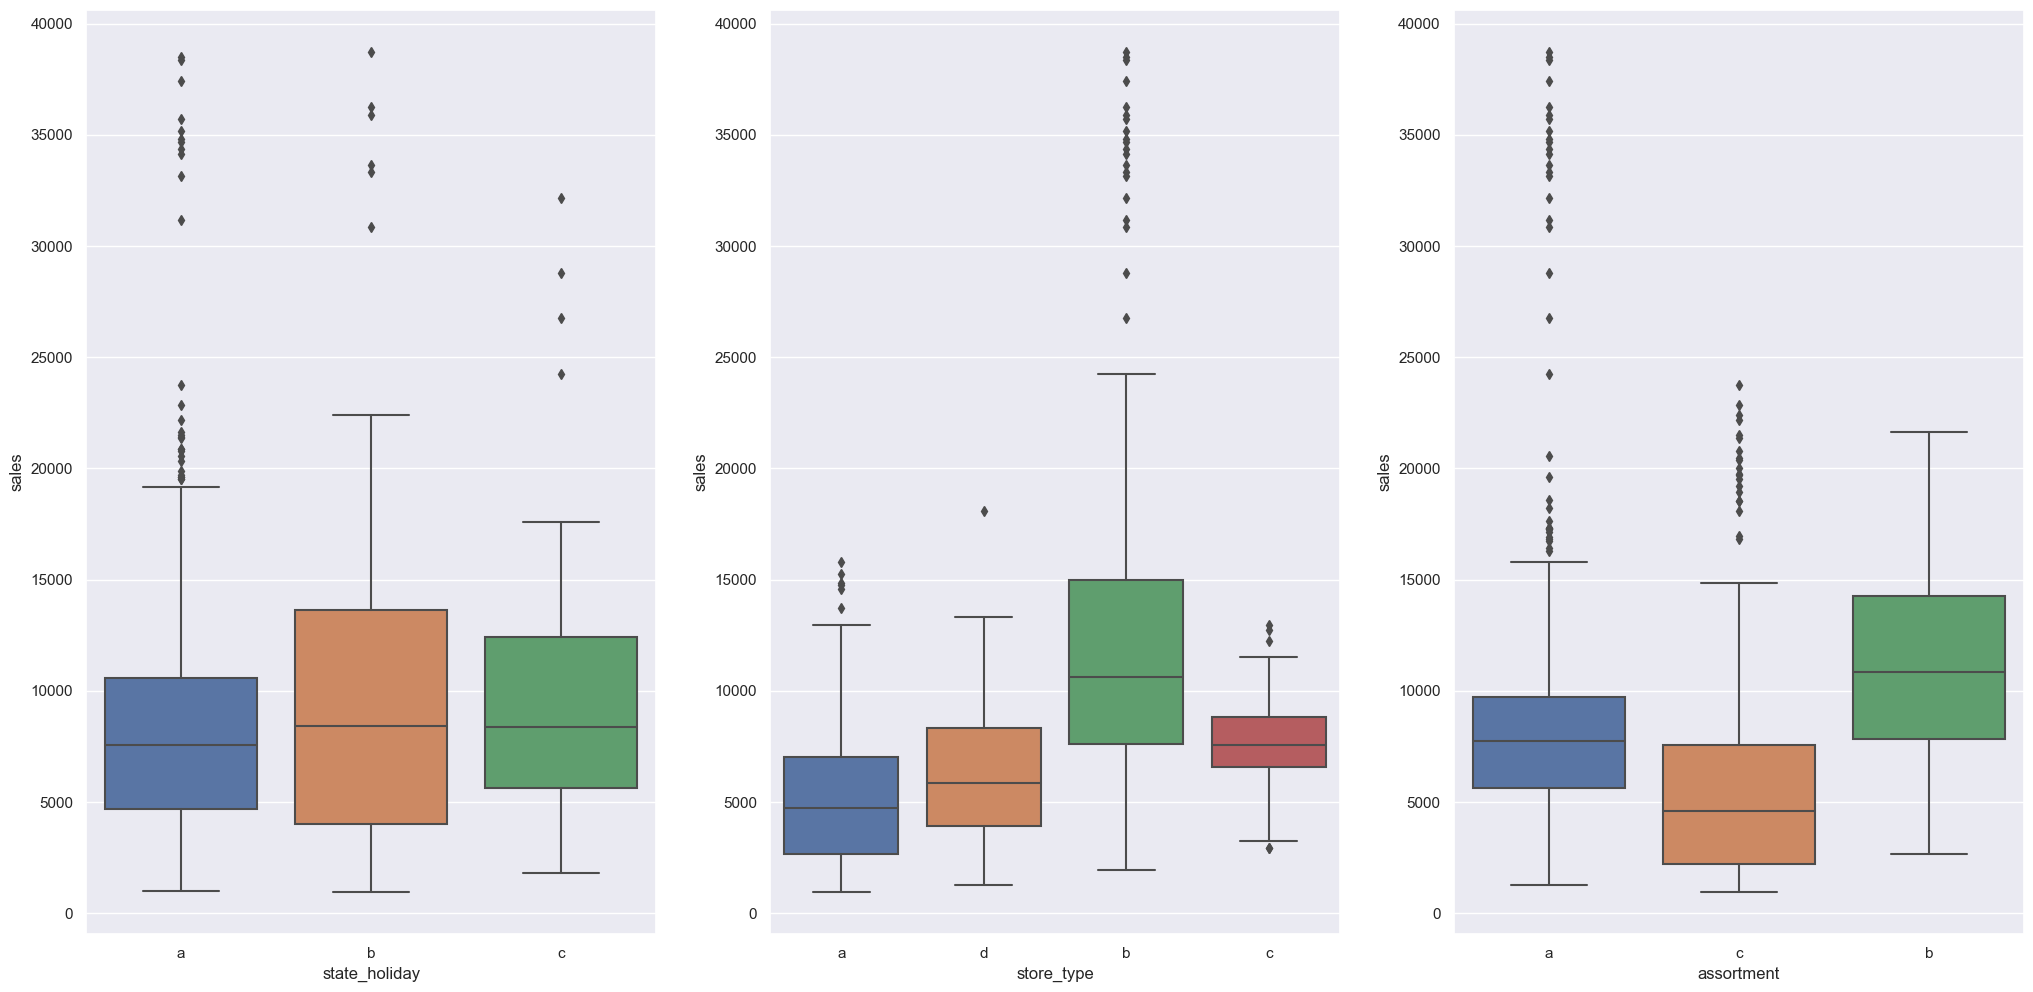

In [23]:
aux1 = df1[ ( df1['state_holiday'] != '0' ) & (df1['sales'] > 0) ]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)
# sns.violinplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)
# sns.violinplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)
# sns.violinplot(x='assortment', y='sales', data=aux1)

# 2.0 PASSO 02 - FEATURE ENGINEERING

In [191]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hiπóteses

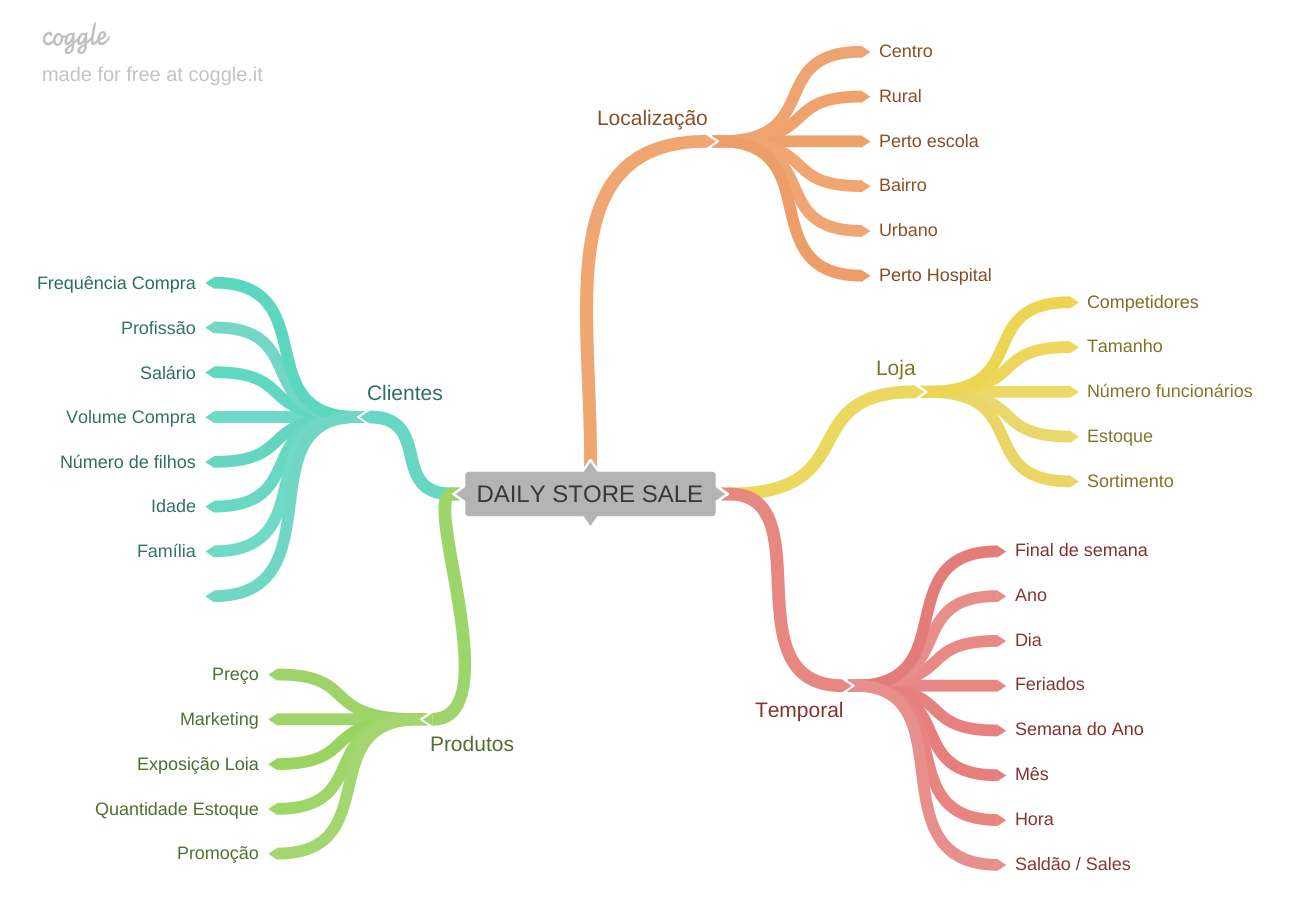

In [27]:
Image('image/MindMapHypothesis.png')

## 2.2 Criação da Hipóteses

### 2.2.1 Hipóteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.2.2 Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Feature Engineering
#### Create new features

In [56]:
# year
df2['year'] = df2.date.dt.year

# month
df2['month'] = df2.date.dt.month

# day
df2['day'] = df2.date.dt.day

# week of year
df2['week_of_year'] = df2.date.dt.isocalendar().week

# year week
df2['year_week'] = df2.date.dt.strftime( '%Y-%W' )

# competition_since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis = 1)
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype( int )

# promo_since
df2['promo_since'] = df2['promo2_since_year'].astype( 'str' ) + '-' + df2['promo2_since_week'].astype( 'str' )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days = 7 ) )
df2['promo_time_week'] = ( ( df2[ 'date' ] - df2['promo_since' ] ) / 7 ).apply( lambda x: x.days ).astype( int )

# assentassent
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas'if x == 'c' else 'regular_day' )


In [58]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [59]:
df3 = df2.copy()

## 3.1 Filtragem da Linhas

In [60]:
# a coluna open indica se a loja está aberta ou fechada, e quando a loja está fechada as vendas é zero, é uma relação direta, então não haverá aprendizado, não quero as linhas cuja a coluna 'open' é  igual a zero.
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção da Colunas

In [61]:
# a coluna customers é uma restrição de negócio, pois não teremos ela disponível no momento da predição.
cols_drop = [ 'customers', 'open', 'promo_interval',  'month_map' ]
df3 = df3.drop( cols_drop, axis = 1 )

In [62]:
list(df3.columns)

['store',
 'day_of_week',
 'date',
 'sales',
 'promo',
 'state_holiday',
 'school_holiday',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'is_promo',
 'year',
 'month',
 'day',
 'week_of_year',
 'year_week',
 'competition_since',
 'competition_time_month',
 'promo_since',
 'promo_time_week']

# 4.0 PASSO 04 - ANÁLISE EXPLORATÓRIA DOS DADOS

In [63]:
df4 = df3.copy()

## 4.1 - Análise Univariada

### 4.1.1 - Variável Resposta

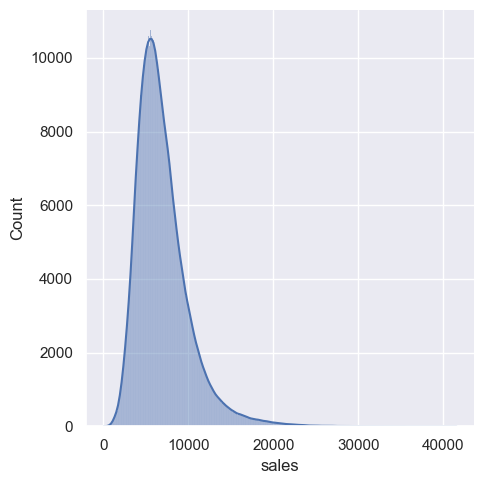

In [64]:
sns.displot( df4['sales'], kde=True );

### 4.1.2 - Numerical Variable

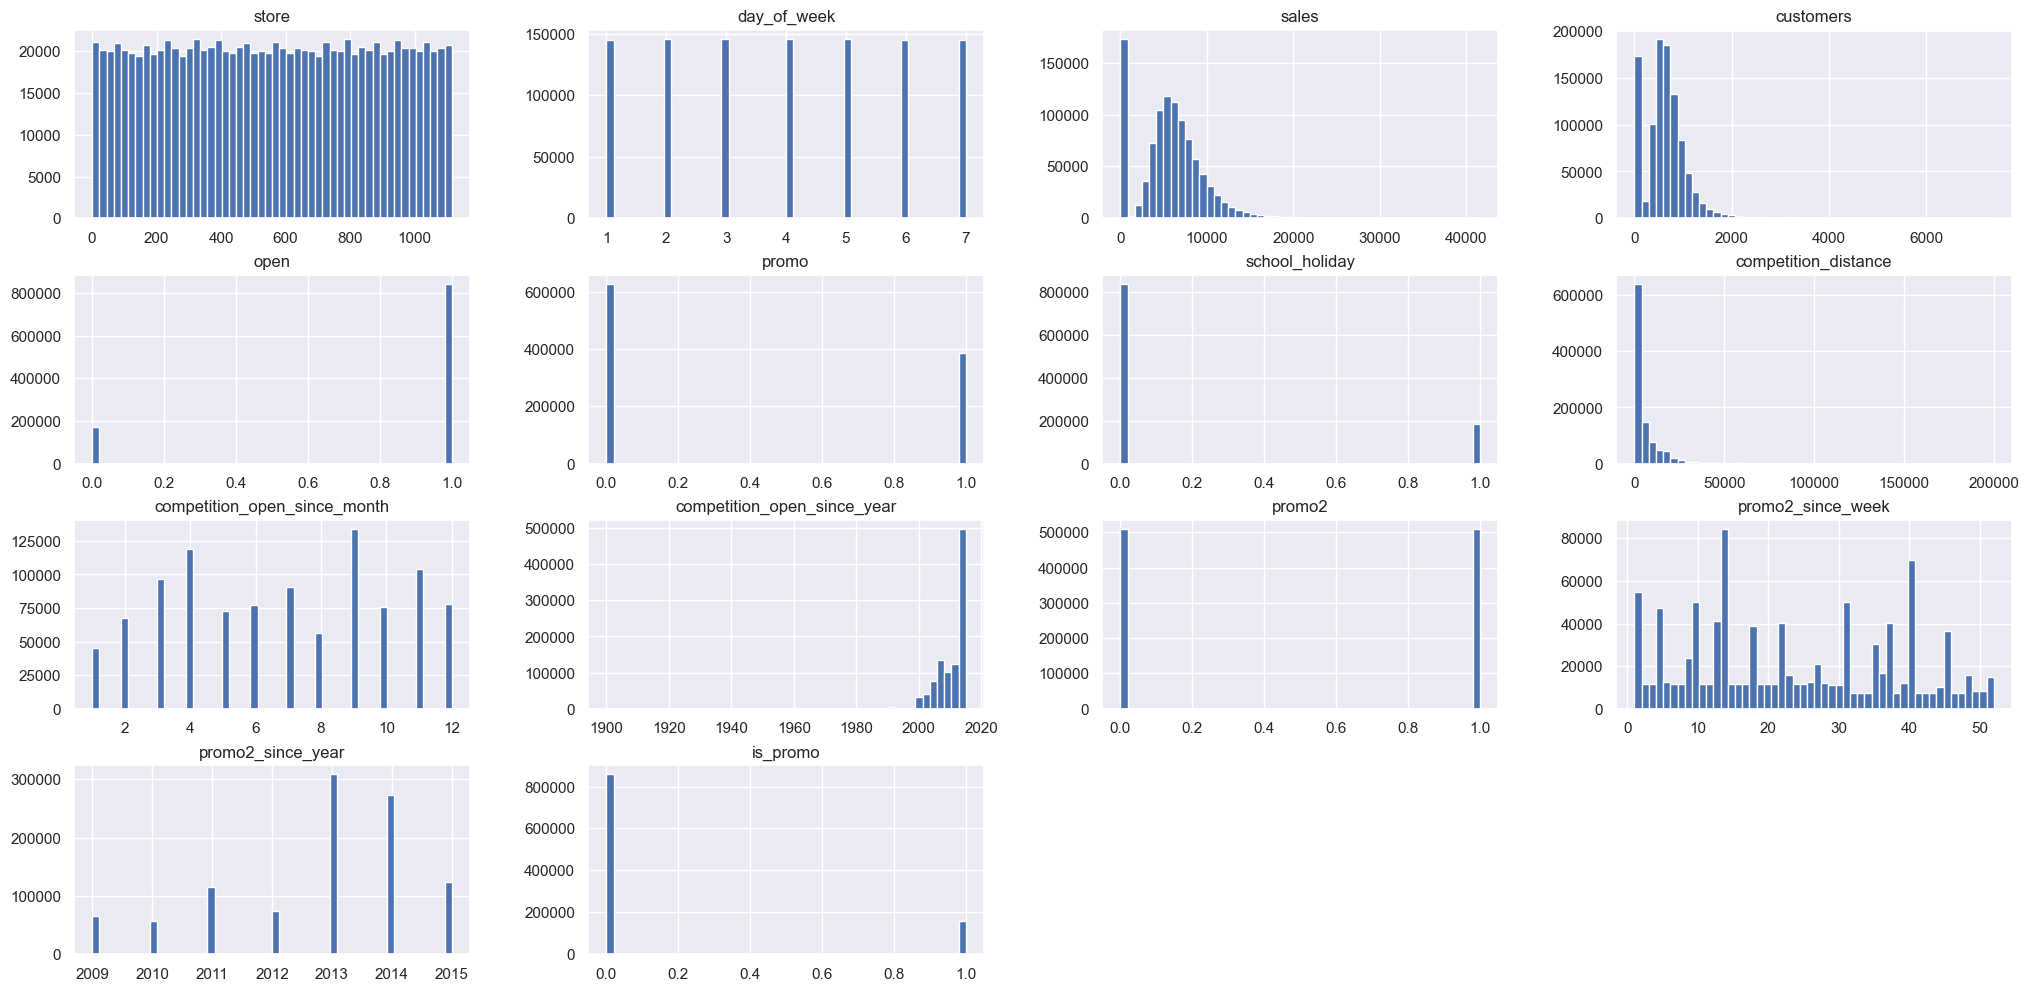

In [65]:
num_attributes.hist( bins=50 );

### 4.1.3 - Categorical Variable

In [66]:
cat_attributes.sample(5)

,state_holiday,store_type,assortment,promo_interval,month_map
538086,0,c,c,0,Mar
729713,0,a,a,"Jan,Apr,Jul,Oct",Sep
807176,0,a,a,"Feb,May,Aug,Nov",Jul
494970,0,a,c,0,Apr
36695,0,c,c,"Mar,Jun,Sept,Dec",Jun


In [67]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

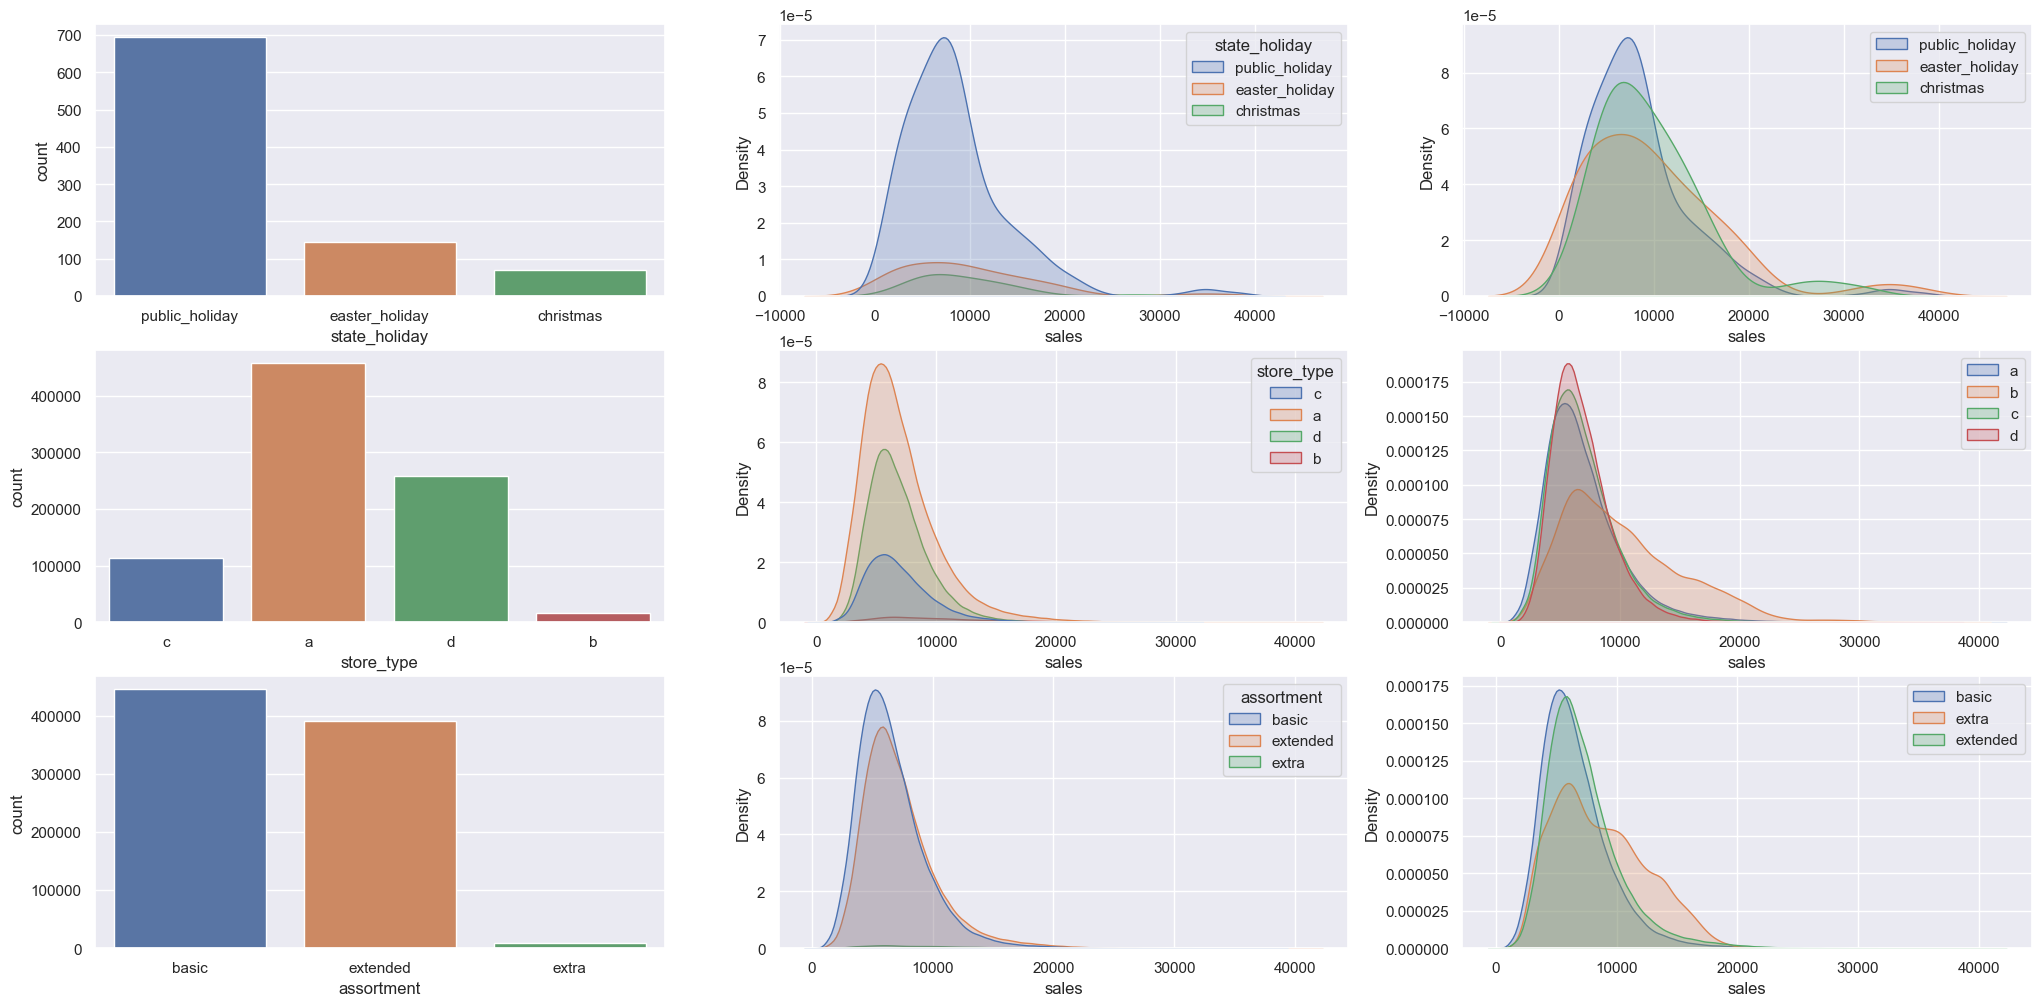

In [68]:
# 'state_holiday'
plt.subplot( 3, 3, 1)
a = df4[ df4[ 'state_holiday' ] != 'regular_day' ]
sns.countplot( x = a['state_holiday'] )

plt.subplot( 3, 3, 2)
sns.kdeplot( df4[ df4[ 'state_holiday' ] != 'regular_day' ], x = 'sales', hue ='state_holiday', fill = True )

plt.subplot( 3, 3, 3)
sns.kdeplot( df4[ df4[ 'state_holiday' ] == 'public_holiday' ]['sales'], label = 'public_holiday', fill = True )
sns.kdeplot( df4[ df4[ 'state_holiday' ] == 'easter_holiday' ]['sales'], label = 'easter_holiday', fill = True )
sns.kdeplot( df4[ df4[ 'state_holiday' ] == 'christmas' ]['sales'], label = 'christmas', fill = True )
plt.legend()

# 'store_type'
plt.subplot( 3, 3, 4)
sns.countplot( x = df4['store_type'] )

plt.subplot( 3, 3, 5)
sns.kdeplot( df4, x = 'sales', hue ='store_type', fill = True )

plt.subplot( 3, 3, 6)
sns.kdeplot( df4[ df4[ 'store_type' ] == 'a' ]['sales'], label = 'a', fill = True )
sns.kdeplot( df4[ df4[ 'store_type' ] == 'b' ]['sales'], label = 'b', fill = True )
sns.kdeplot( df4[ df4[ 'store_type' ] == 'c' ]['sales'], label = 'c', fill = True )
sns.kdeplot( df4[ df4[ 'store_type' ] == 'd' ]['sales'], label = 'd', fill = True )
plt.legend()

# 'assortment'
plt.subplot( 3, 3, 7)
sns.countplot( x = df4['assortment'] )

plt.subplot( 3, 3, 8)
sns.kdeplot( df4, x = 'sales', hue ='assortment', fill = True )

plt.subplot( 3, 3, 9)
sns.kdeplot( df4[ df4[ 'assortment' ] == 'basic' ]['sales'], label = 'basic', fill = True )
sns.kdeplot( df4[ df4[ 'assortment' ] == 'extra' ]['sales'], label = 'extra', fill = True )
sns.kdeplot( df4[ df4[ 'assortment' ] == 'extended' ]['sales'], label = 'extended', fill = True )
plt.legend()


## 4.2 - Análise Bivariada

### **H1.** Lojas com maior sortimentos deveriam vender mais.
**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

<Axes: xlabel='year_week'>

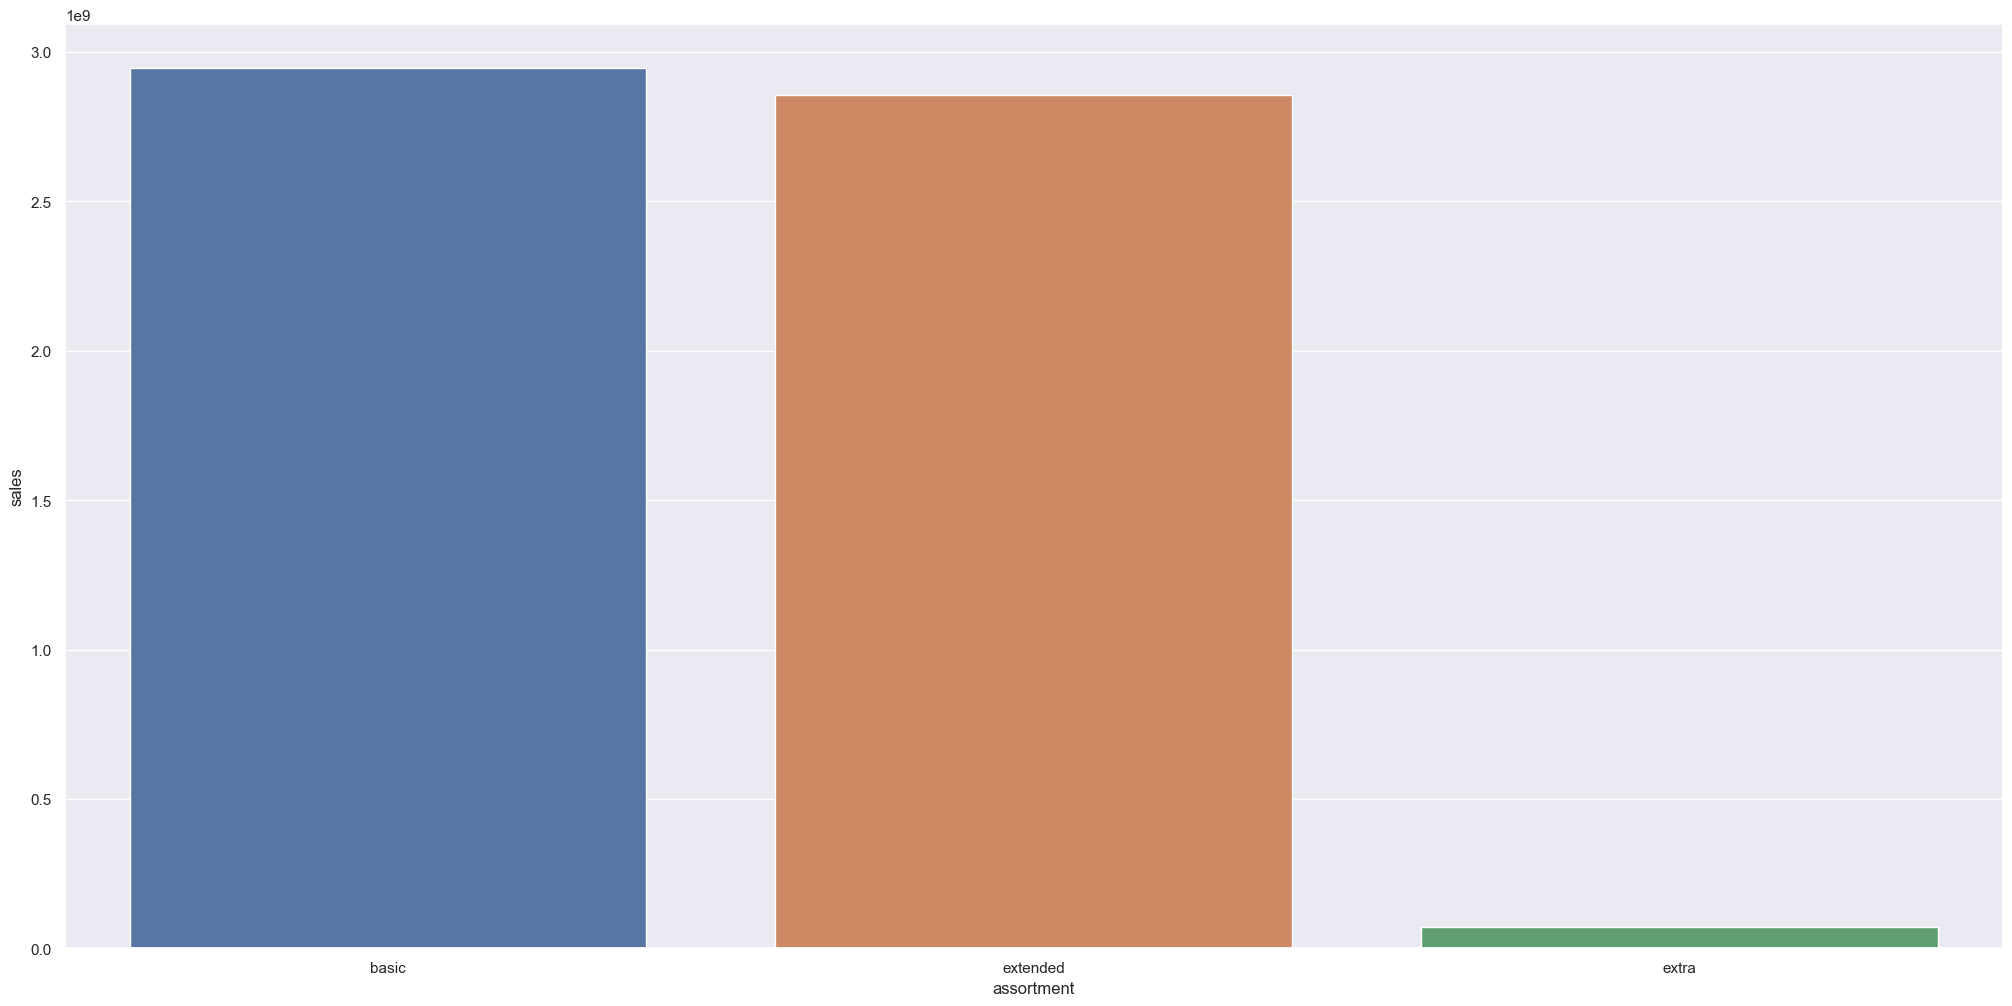

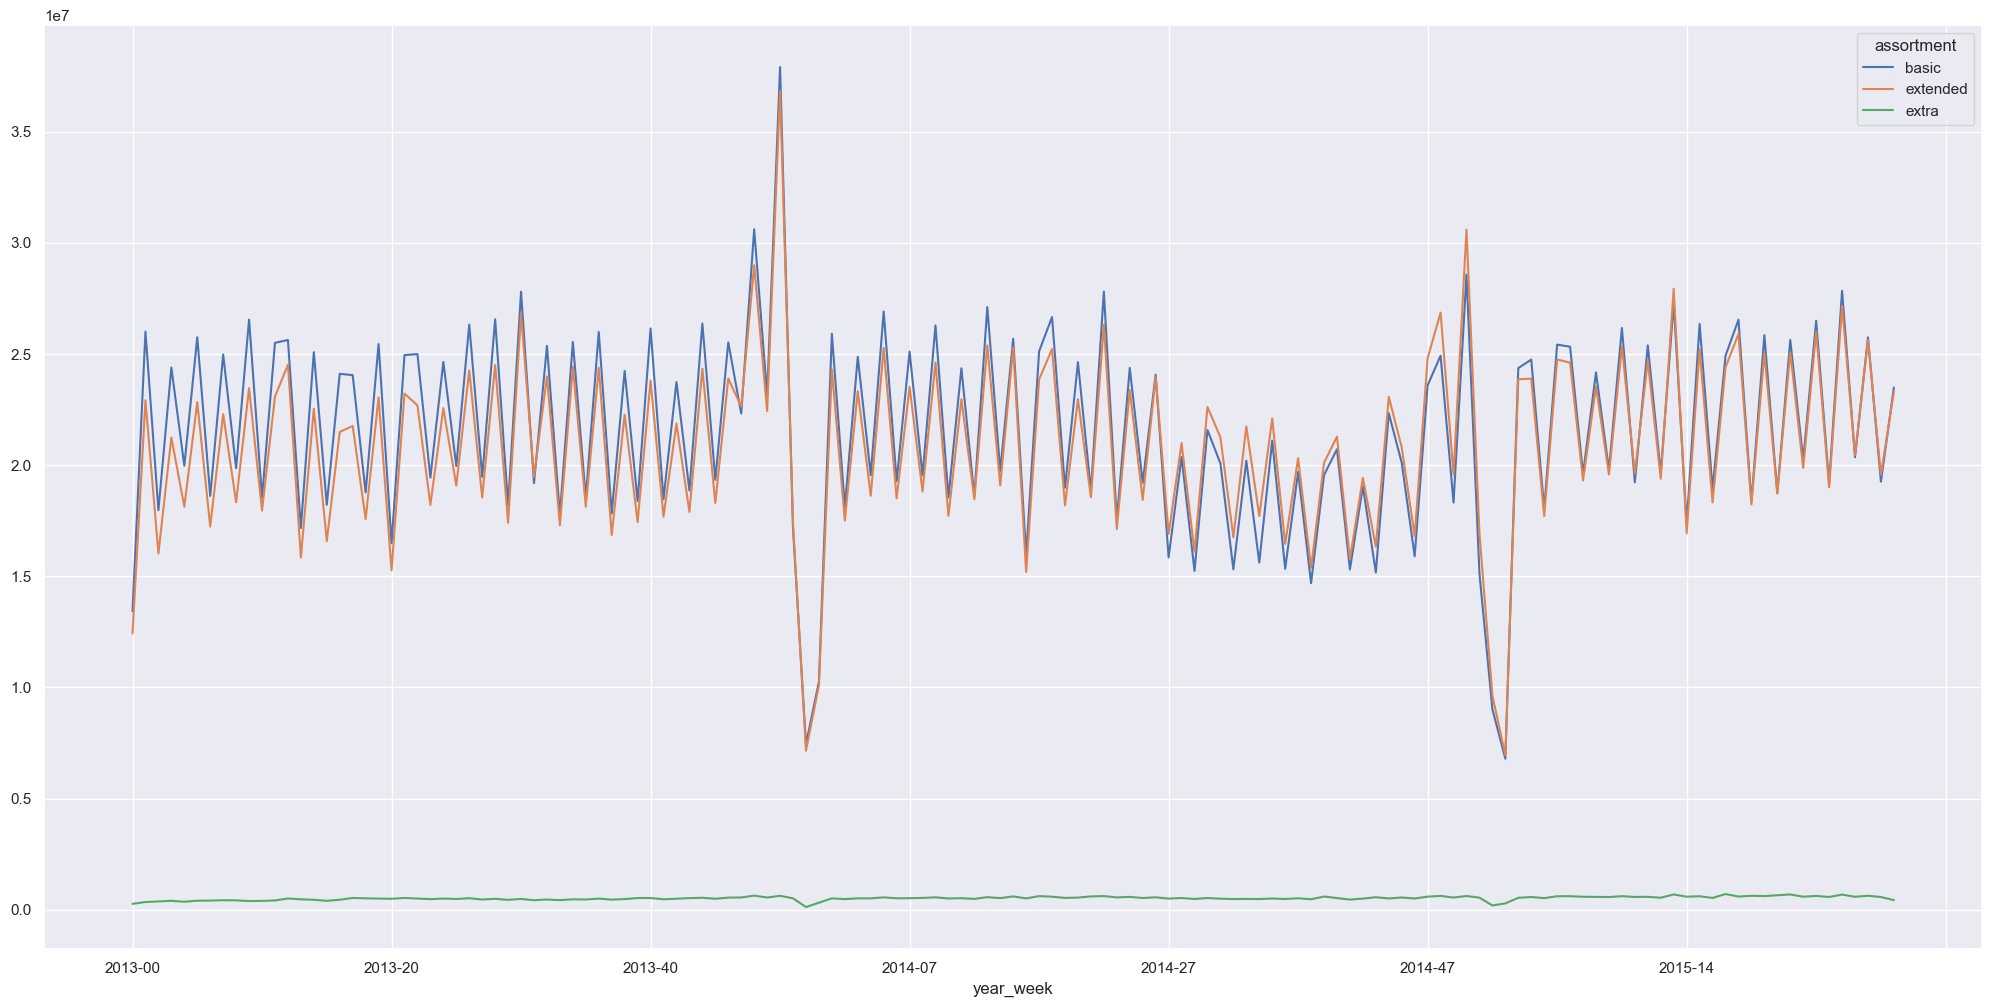

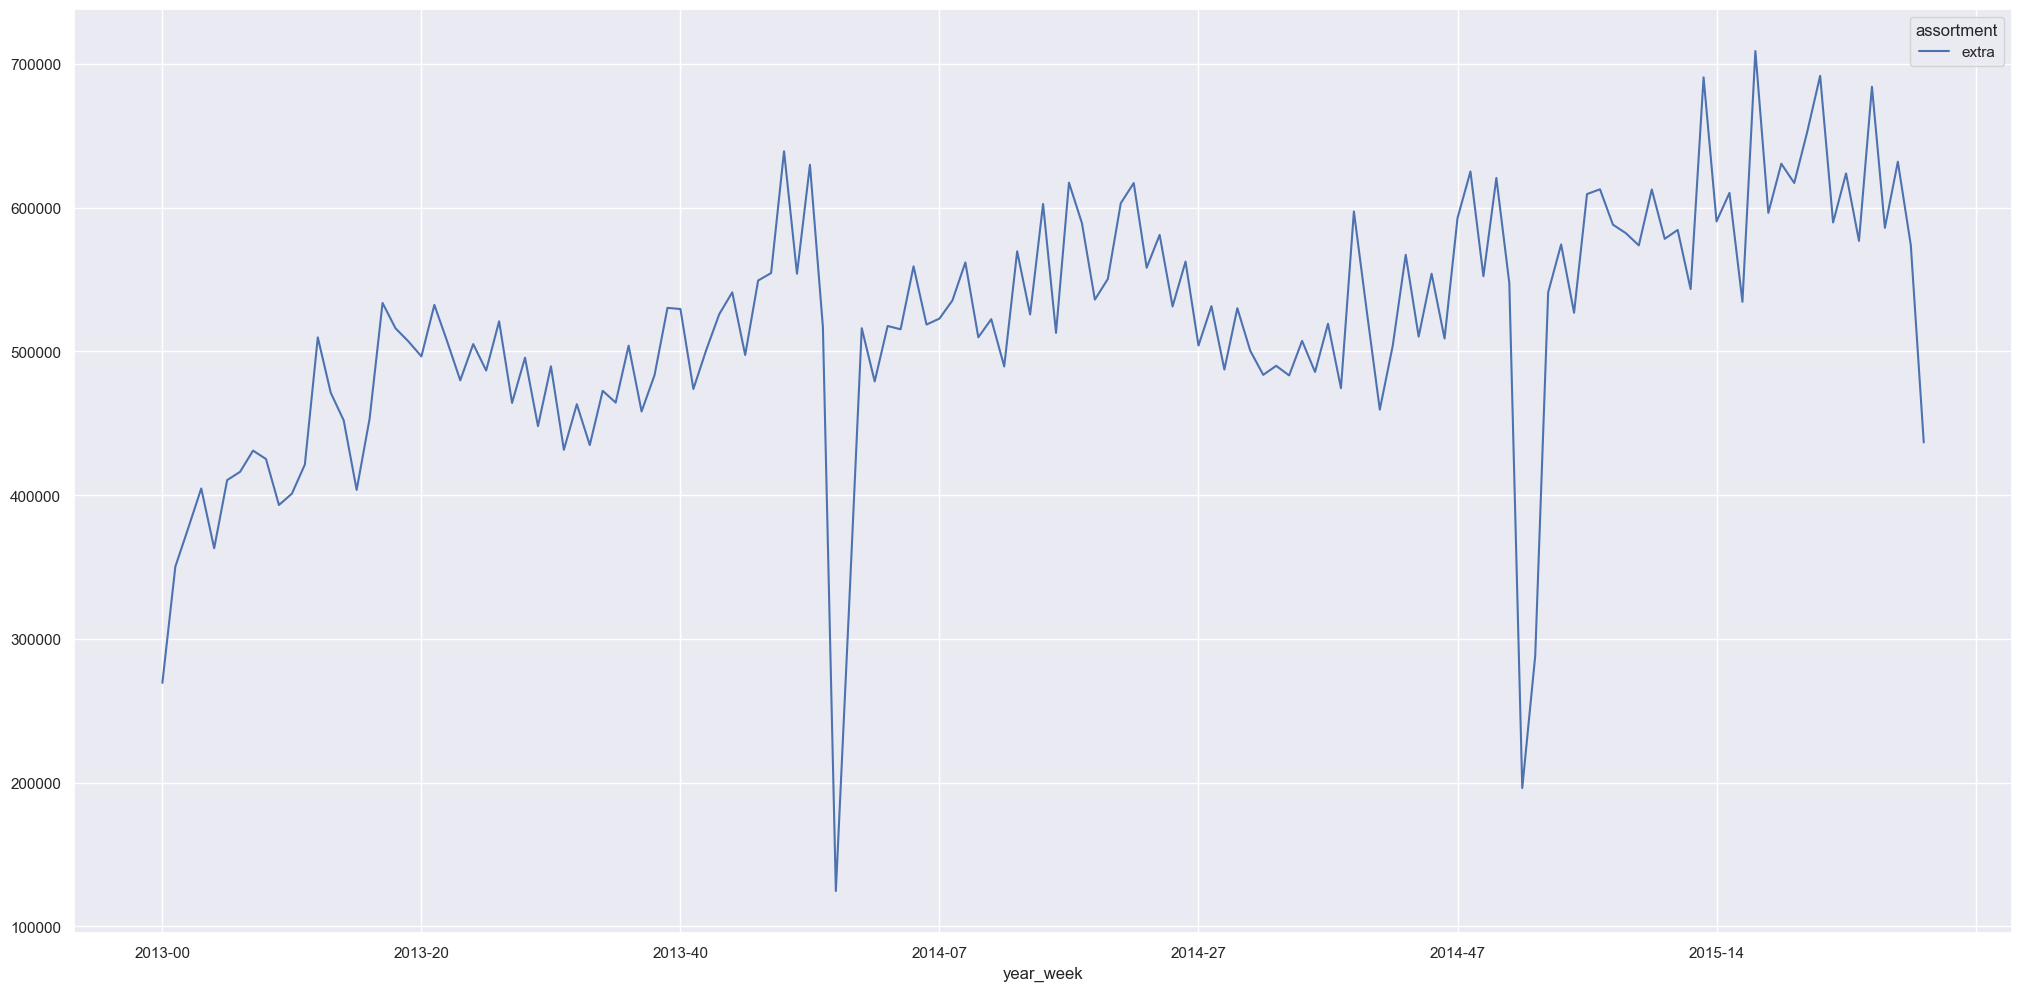

In [69]:
aux1 = df4[ [ 'assortment', 'sales' ] ].groupby( 'assortment' ).sum().reset_index()
sns.barplot(data = aux1, x = 'assortment', y = 'sales');

aux2 = df4[ [ 'year_week', 'assortment', 'sales' ] ].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()

aux3 = aux2[ aux2['assortment'] == 'extra' ]
aux3.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PROXIMOS vendes MAIS.

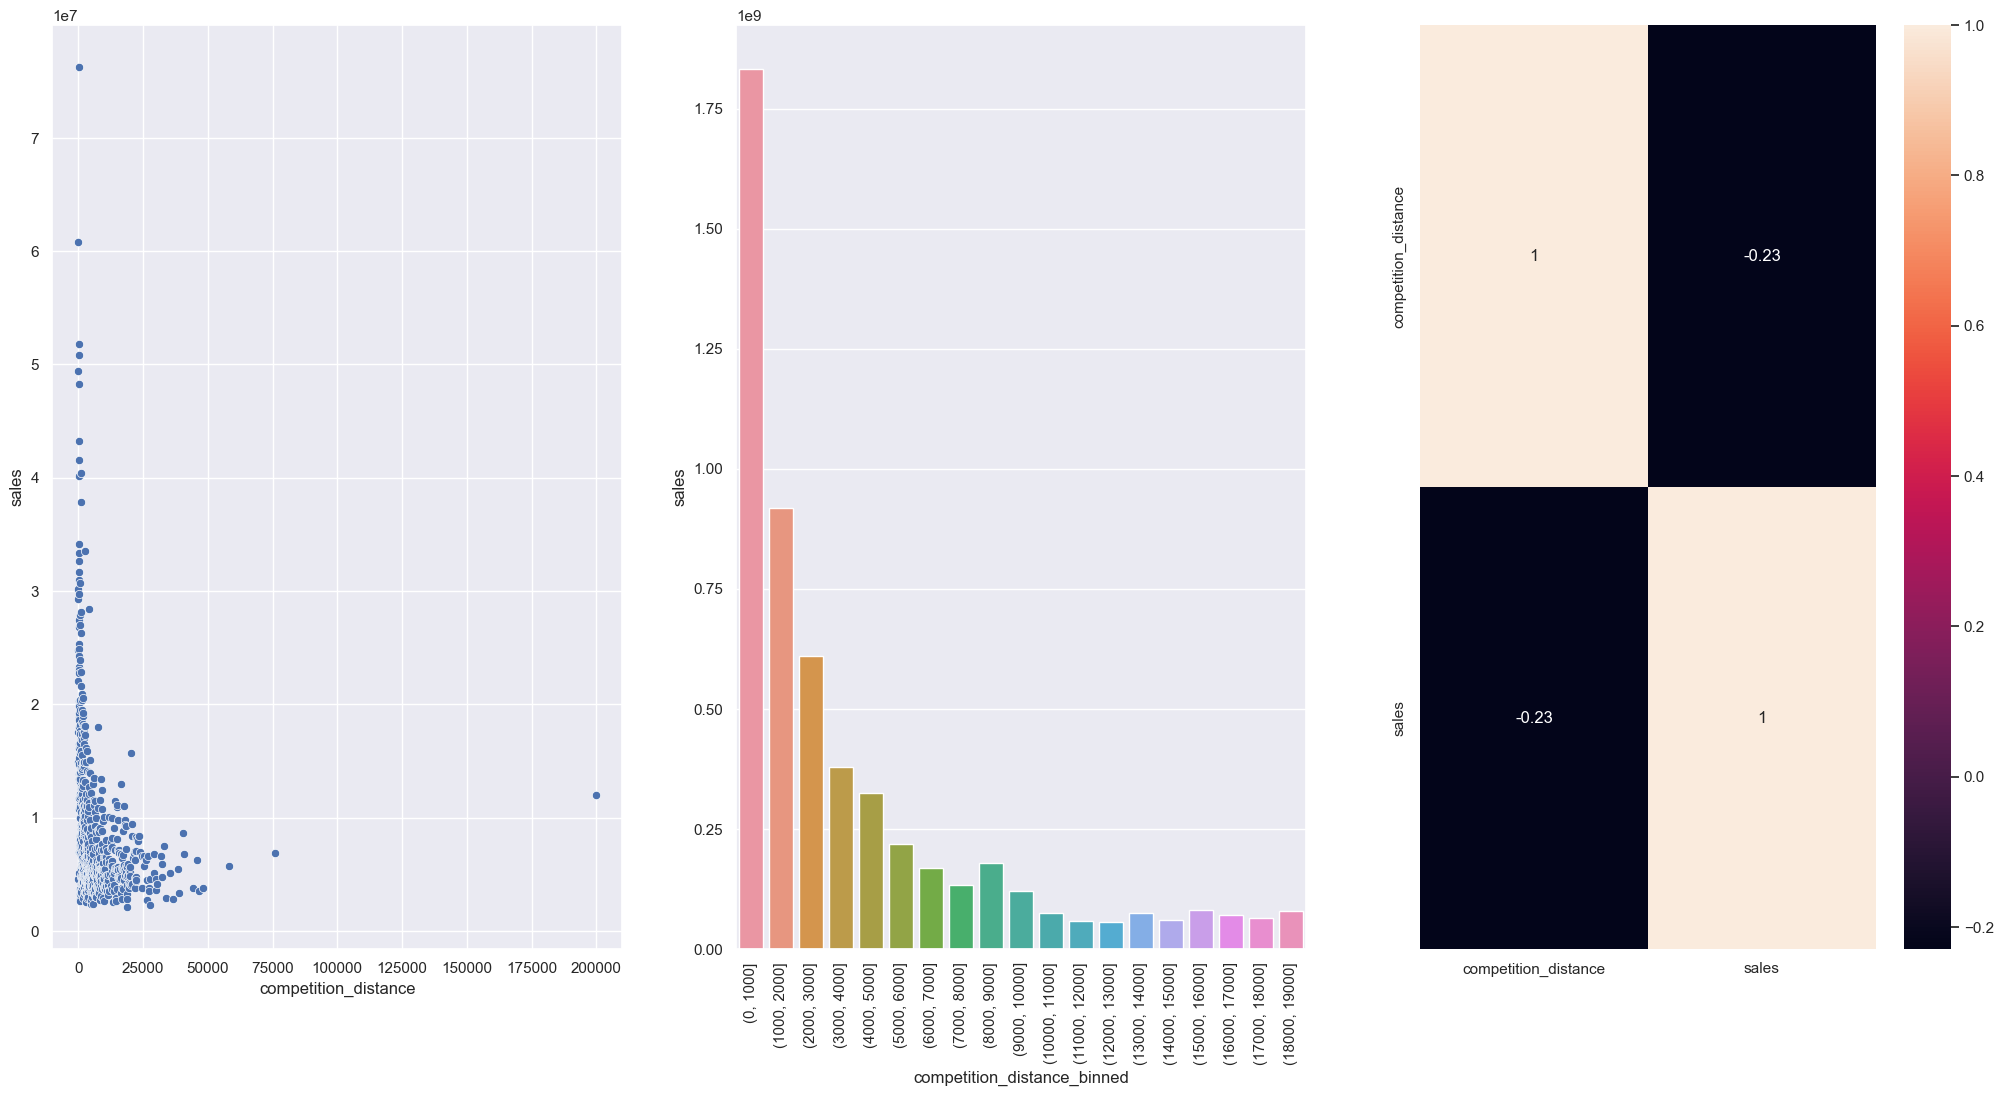

In [70]:
plt.subplot( 1, 3, 1 )
aux4 = df4[ ['competition_distance', 'sales'] ].groupby('competition_distance').sum().reset_index()
sns.scatterplot(data = aux4, x = 'competition_distance', y = 'sales');

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000 ))
aux4['competition_distance_binned'] = pd.cut( aux4['competition_distance'], bins = bins)
aux5 = aux4[ [ 'competition_distance_binned', 'sales' ] ].groupby(['competition_distance_binned']).sum().reset_index()
sns.barplot(data = aux5, x = 'competition_distance_binned', y = 'sales')
plt.xticks( rotation = 90 )

plt.subplot ( 1, 3, 3 )
sns.heatmap( aux4[ [ 'competition_distance', 'sales' ] ].corr( method = 'pearson'), annot = True );
# x = sns.heatmap( aux4[ [ 'competition_distance', 'sales' ] ].corr( method = 'pearson'), annot = True );
# bottom, top = x.get_Ylim()
# x.set_ylim( bottom+0.5, top-0.5 );


### **H3.** Lojas com competidores à mais tempo deveriam vender mais.
**FALSA** Lojas com competidores a MAIS tempo vendem MENOS.


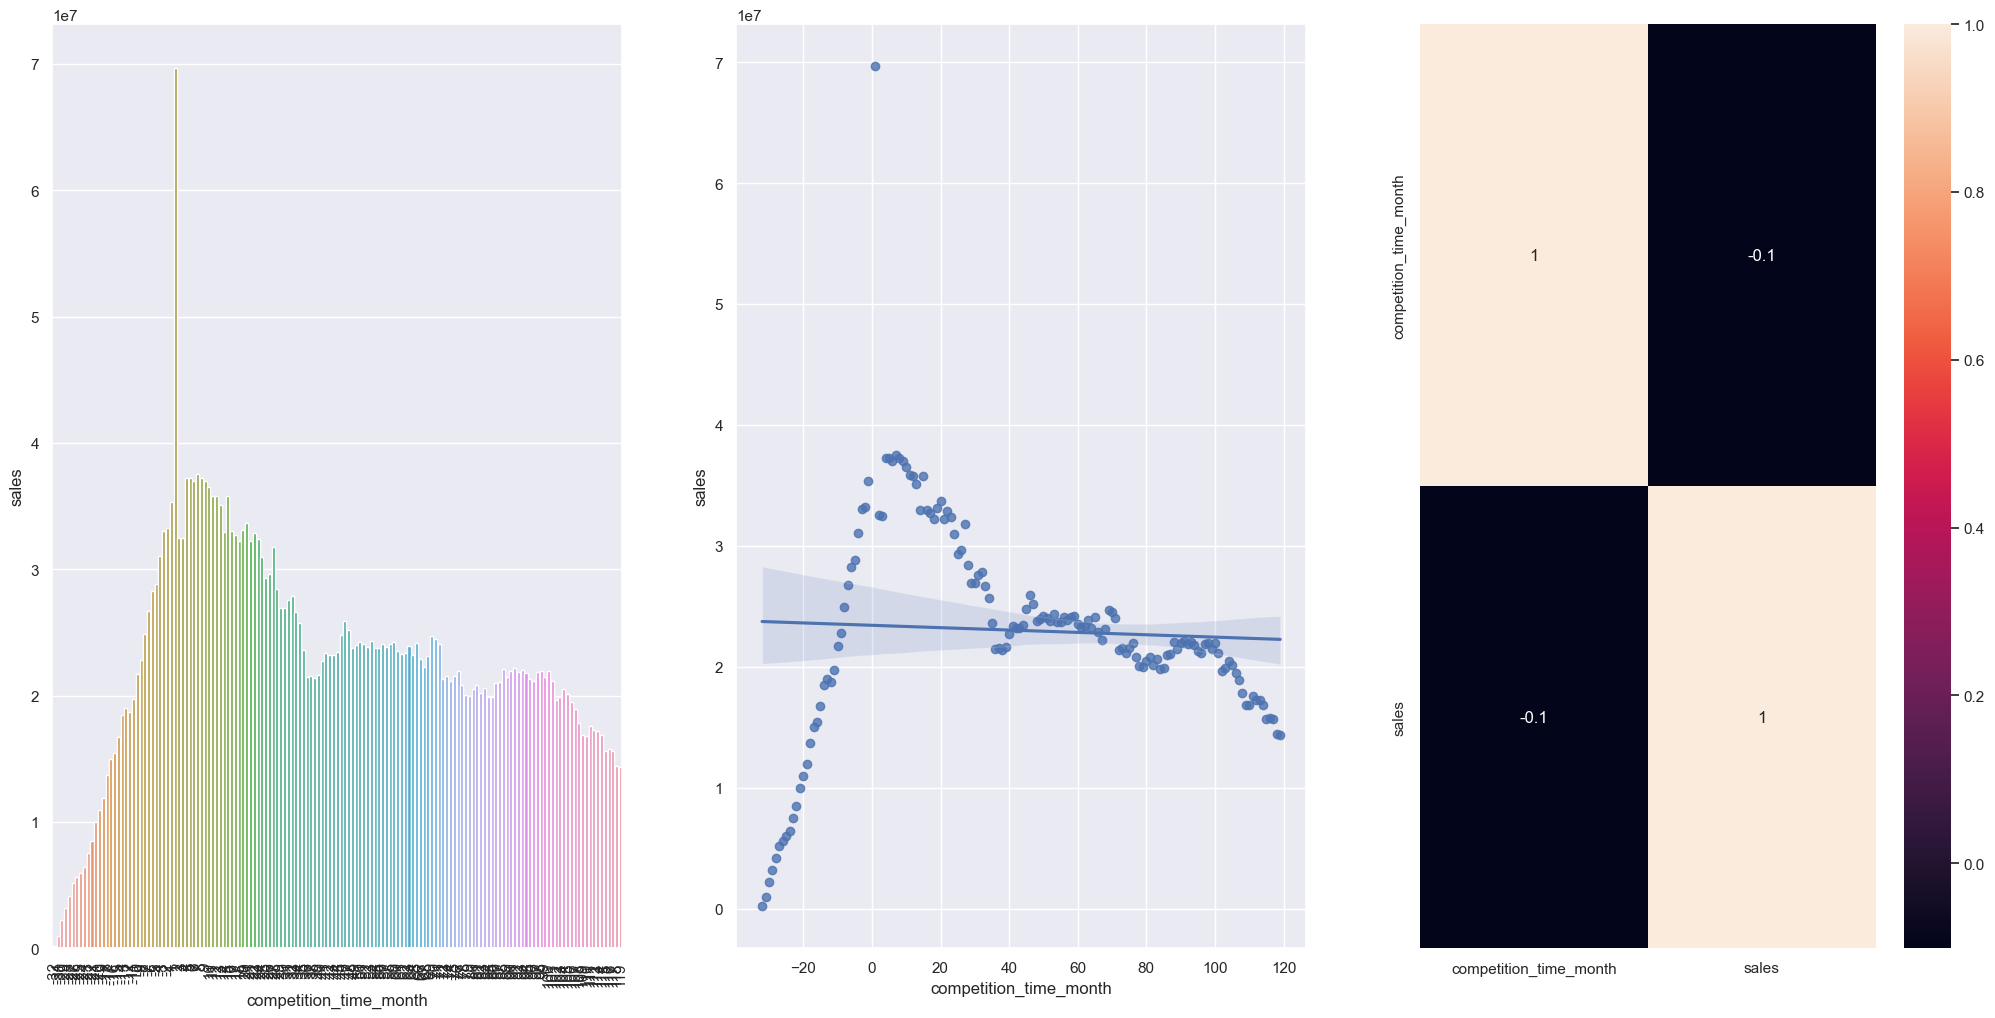

In [71]:
aux1 = df4[['competition_time_month', 'sales' ]].groupby(['competition_time_month']).sum().reset_index()
aux2 = aux1[ ( aux1[ 'competition_time_month' ] < 120 ) & ( aux1[ 'competition_time_month' ] != 0 ) ]

plt.subplot(1, 3, 1)
sns.barplot(data = aux2, x = 'competition_time_month', y = 'sales');
plt.xticks( rotation = 90 )

plt.subplot(1, 3, 2)
sns.regplot(data = aux2, x = 'competition_time_month', y = 'sales');

plt.subplot(1, 3, 3)
sns.heatmap( aux1[ [ 'competition_time_month', 'sales' ] ].corr( method = 'pearson'), annot = True );
# x = sns.heatmap( aux1[ [ 'competition_time_month', 'sales' ] ].corr( method = 'pearson'), annot = True );
# bottom, top = x.get_ylim()
# x.set_ylim( bottom+0.5, top-0.5 );


### **H4**. Lojas com promoções ativas por mais tempo deveriam vender mais
**FALSA** Lojas com promocoes ativas por MAIS tempo vendem MENOS, depois de um certo periodo de promocao.

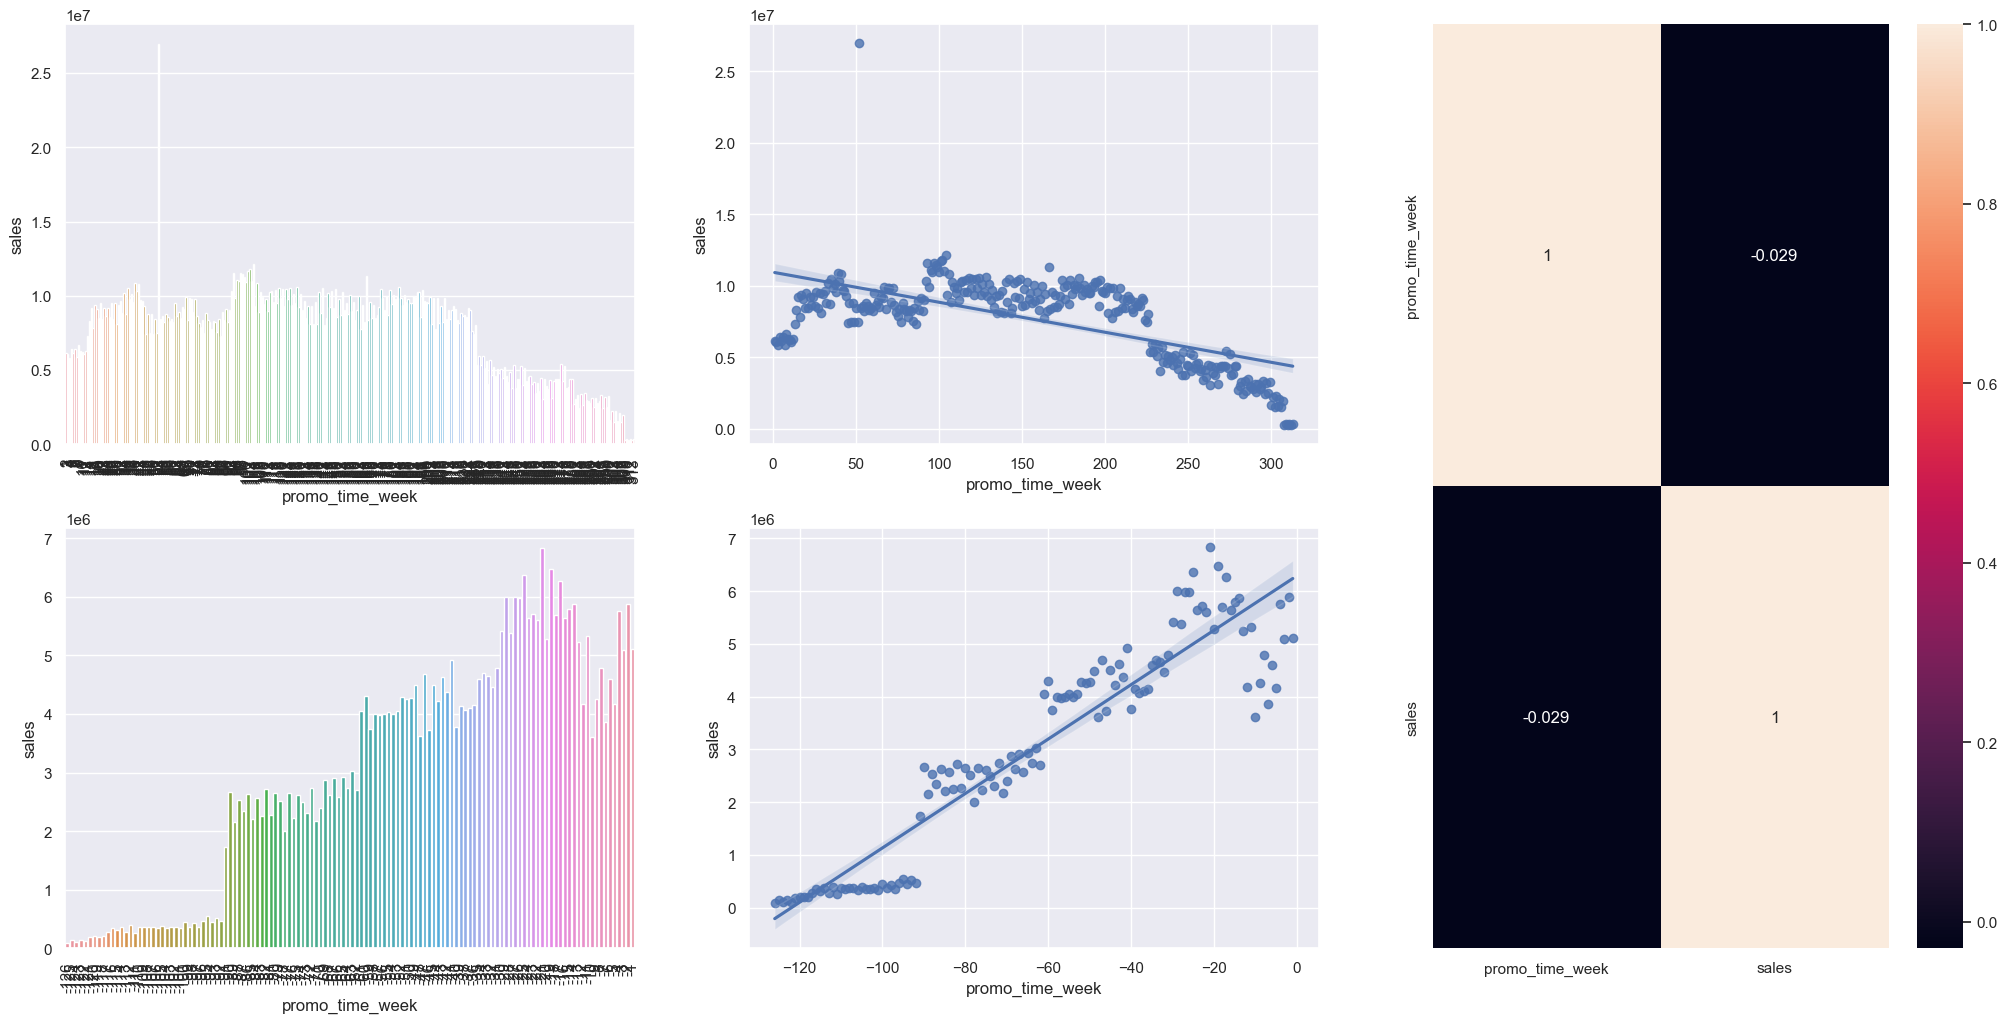

In [72]:
grid = gridspec.GridSpec(2, 3)

aux1 = df4[ [ 'promo_time_week', 'sales' ] ].groupby( [ 'promo_time_week' ] ).sum().reset_index()
aux2 = aux1[ aux1[ 'promo_time_week' ] > 0 ] # promo extendida
aux3 = aux1[ aux1[ 'promo_time_week' ] < 0 ] # promo regular

plt.subplot( grid[ 0, 0 ] )
sns.barplot( data = aux2, x = 'promo_time_week', y = 'sales' );
plt.xticks( rotation = 90 )

plt.subplot( grid[ 0, 1 ] )
sns.regplot( data = aux2, x = 'promo_time_week', y = 'sales' );


plt.subplot( grid[ 1, 0 ] )
sns.barplot( data = aux3, x = 'promo_time_week', y = 'sales' );
plt.xticks( rotation = 90 )

plt.subplot( grid[ 1, 1 ] )
sns.regplot( data = aux3, x = 'promo_time_week', y = 'sales' );

plt.subplot( grid[ :, 2 ] )
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True );


### <s>**H5**. Lojas com mais dias de promoção deveriam vender mais.</s>


### **H6**. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com MAIS promocoes consecutivas vendem MENOS.

In [73]:
df4[ [ 'promo', 'promo2', 'sales' ] ].groupby( [ 'promo', 'promo2' ] ).sum().reset_index().sort_values('sales')

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


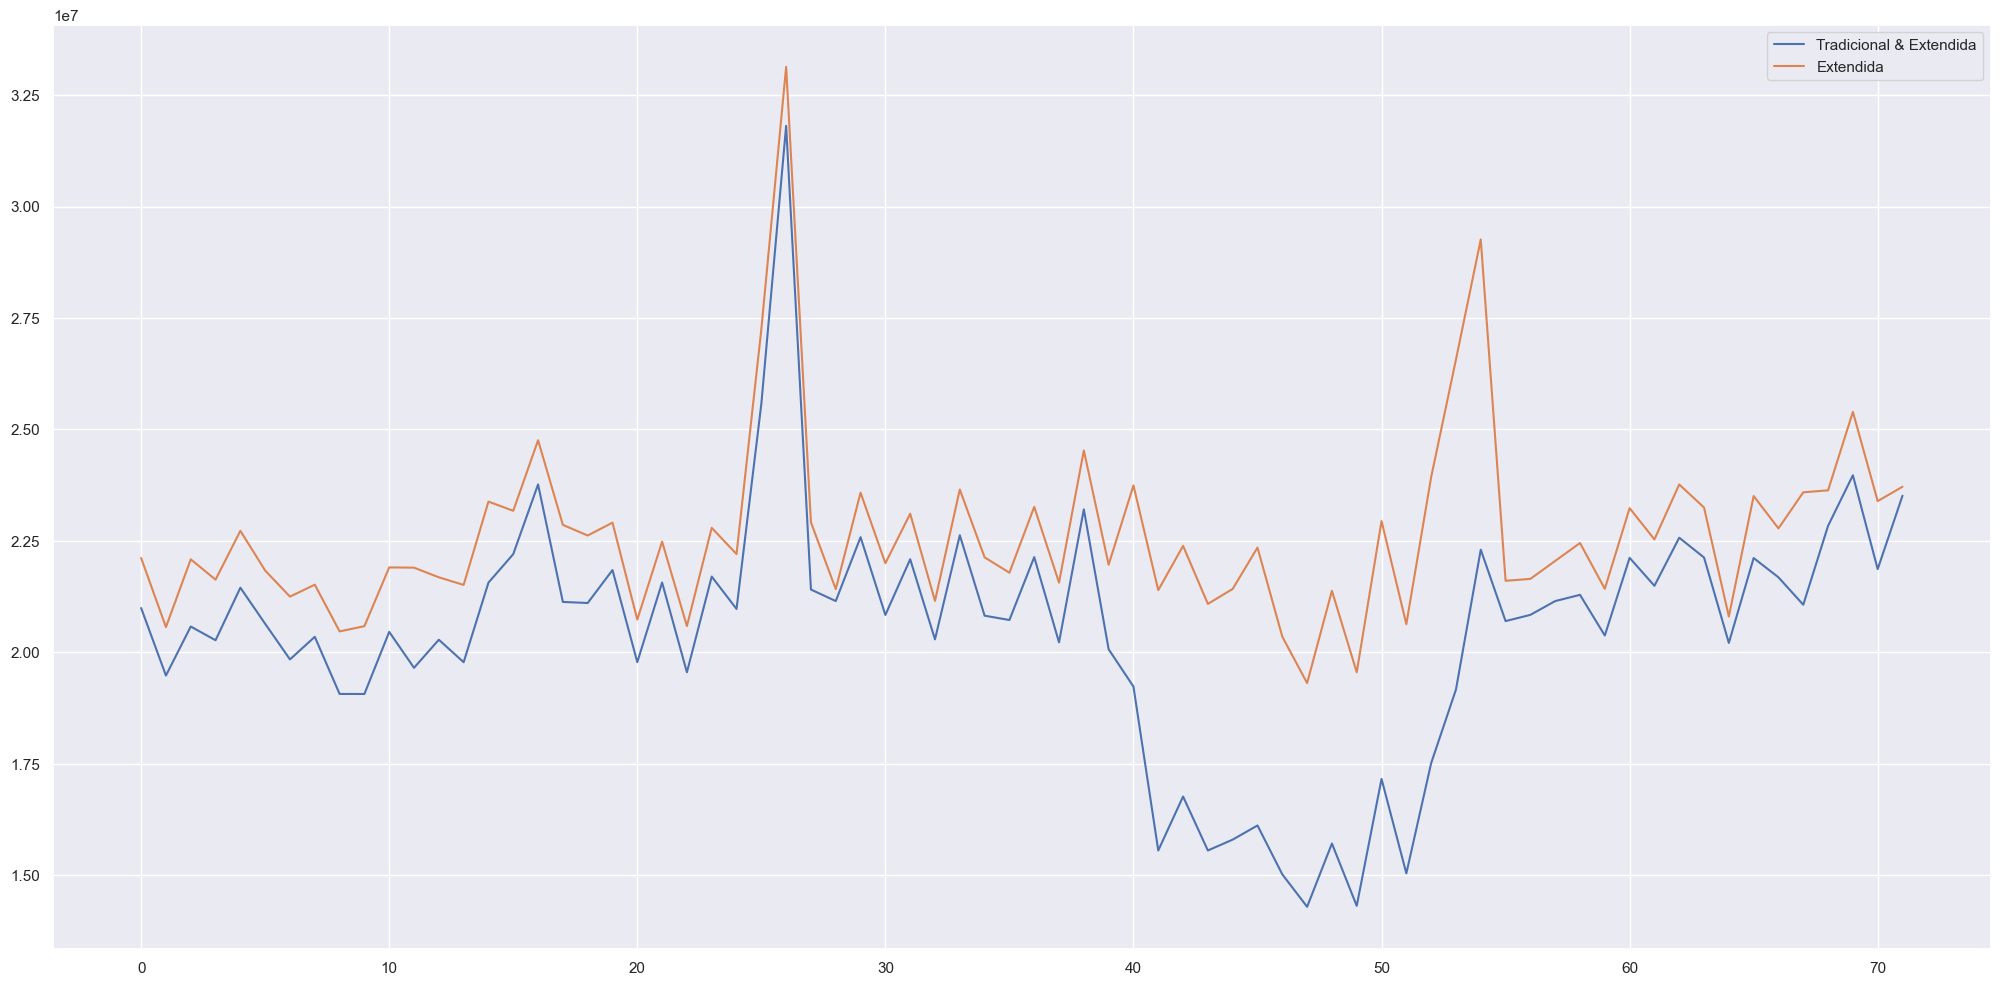

In [45]:
aux1 = df4[ ( df4[ 'promo'] == 1 ) & ( df4[ 'promo2'] == 1 ) ][ [ 'year_week', 'sales' ] ].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[ ( df4[ 'promo'] == 1 ) & ( df4[ 'promo2'] == 0 ) ][ [ 'year_week', 'sales' ] ].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax = ax );

ax.legend( labels = [ 'Tradicional & Extendida',  'Extendida' ] );

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado do Natal vendem menos.

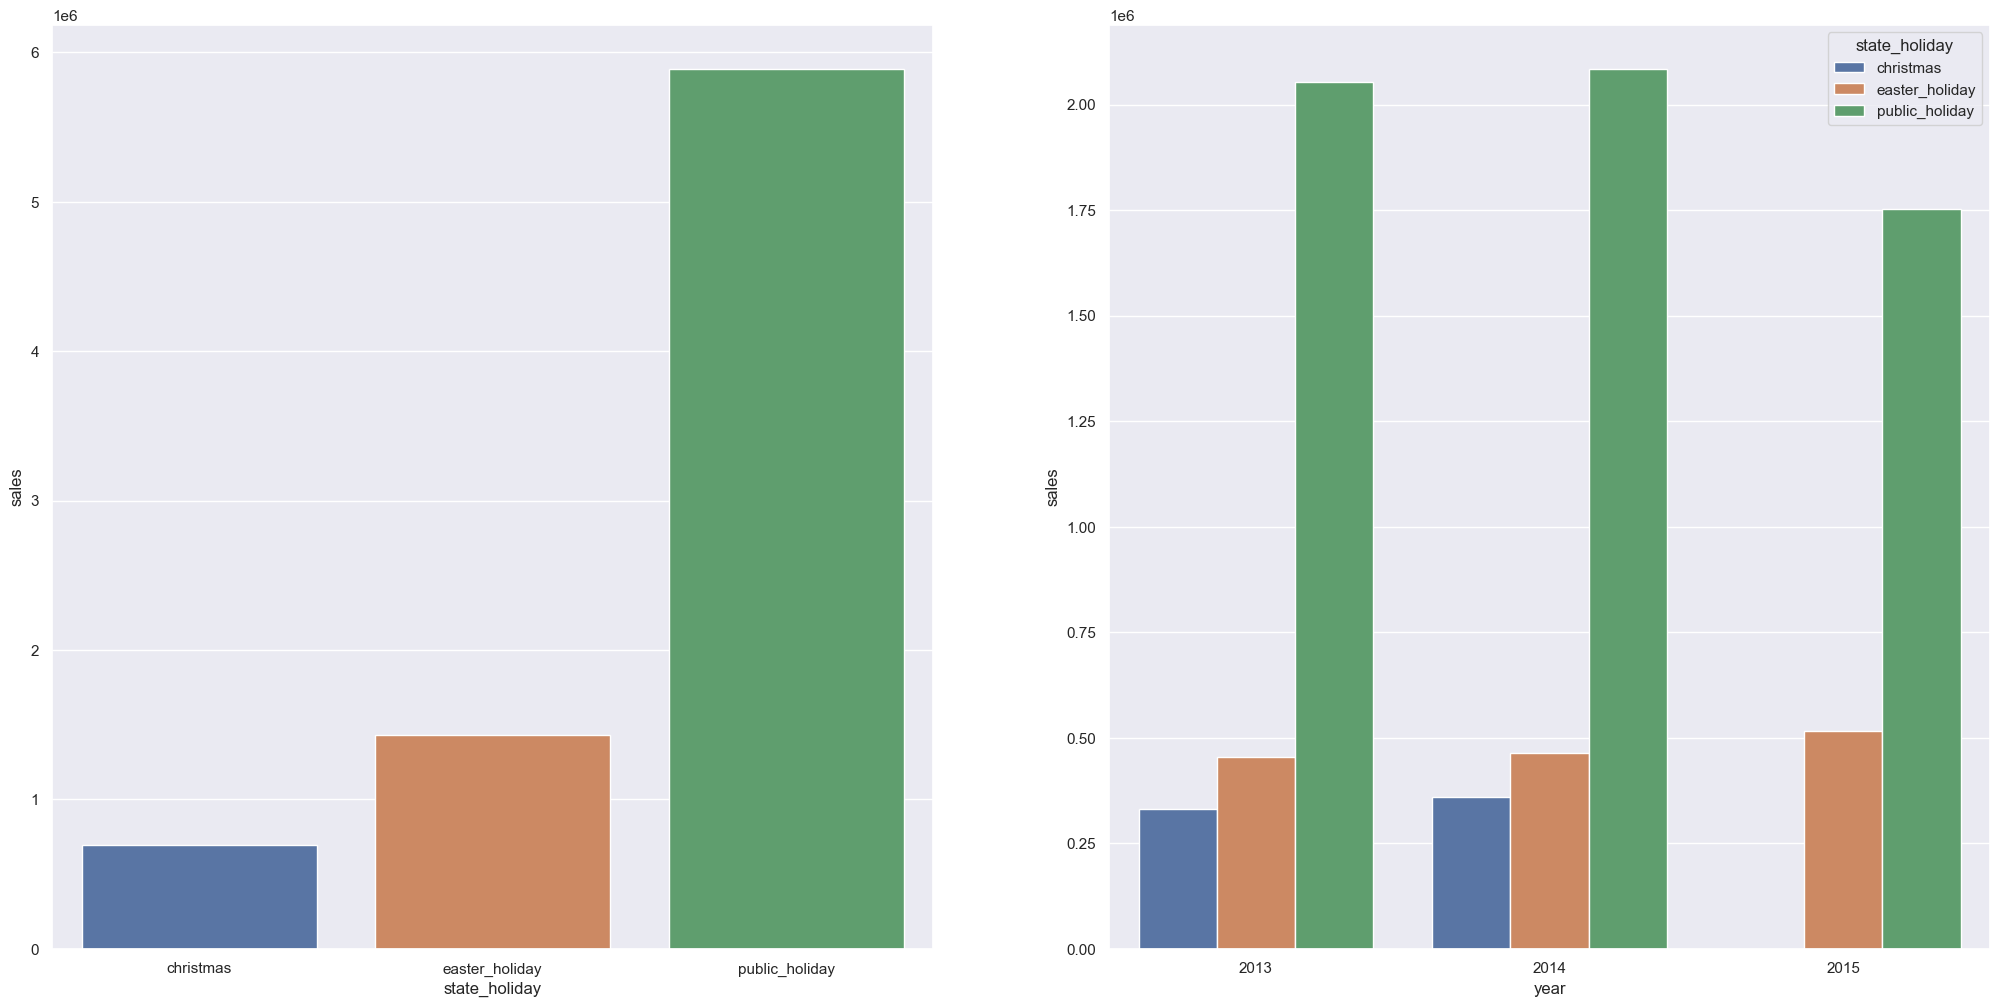

In [46]:
aux1 = df4[df4['state_holiday'] != 'regular_day']
aux2 = aux1[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
aux3 = aux1[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()

plt.subplot(1, 2, 1)
sns.barplot(data = aux2, x = 'state_holiday', y = 'sales');

plt.subplot(1, 2, 2)
sns.barplot(data = aux3, x = 'year', y = 'sales', hue = 'state_holiday');

### **H8.** Lojas deveriam vender mais ao longo dos anos.
**FALSA** LOjas vendem MENOS ao longo dos anos.

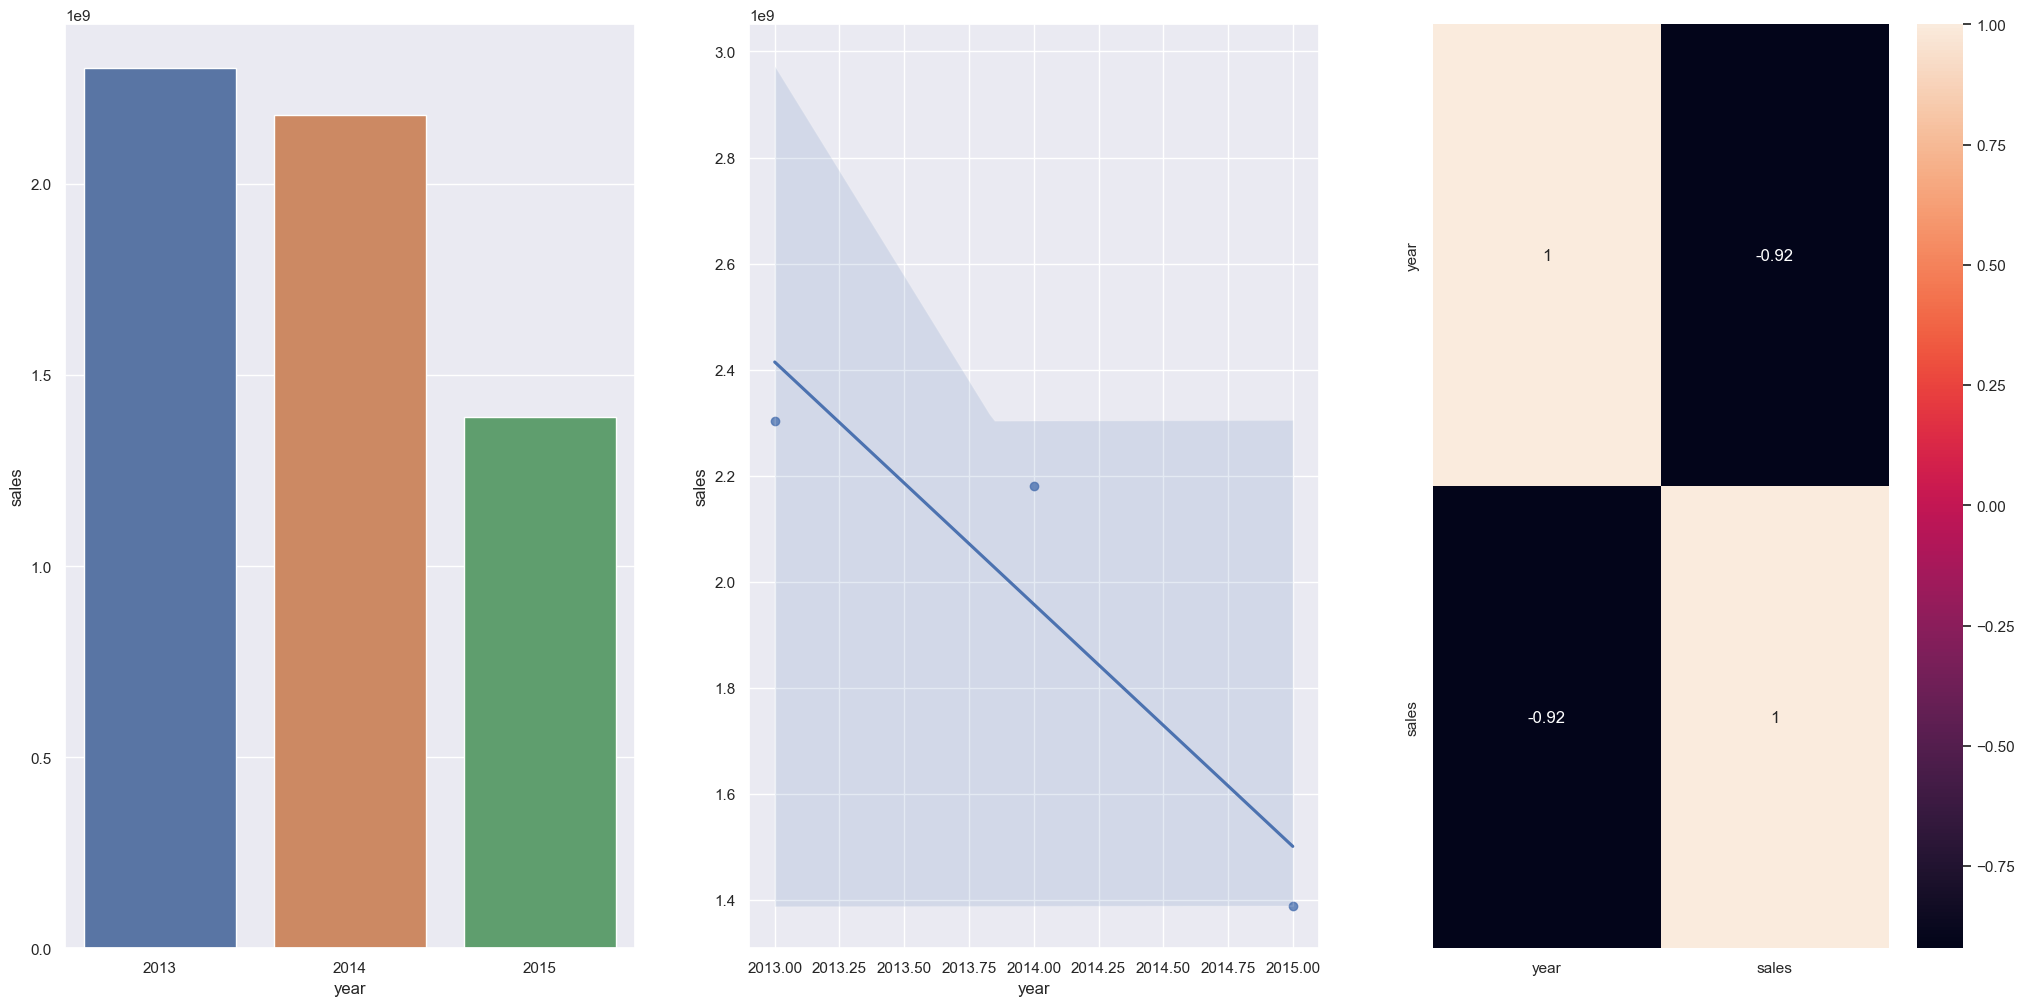

In [47]:
aux1 = df4[ [ 'year', 'sales' ] ].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(data = aux1, x = 'year', y = 'sales');

plt.subplot(1, 3, 2)
sns.regplot(data = aux1, x = 'year', y = 'sales');

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot = True);

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** Lojas vendem MENOS no segundo semestre do ano.

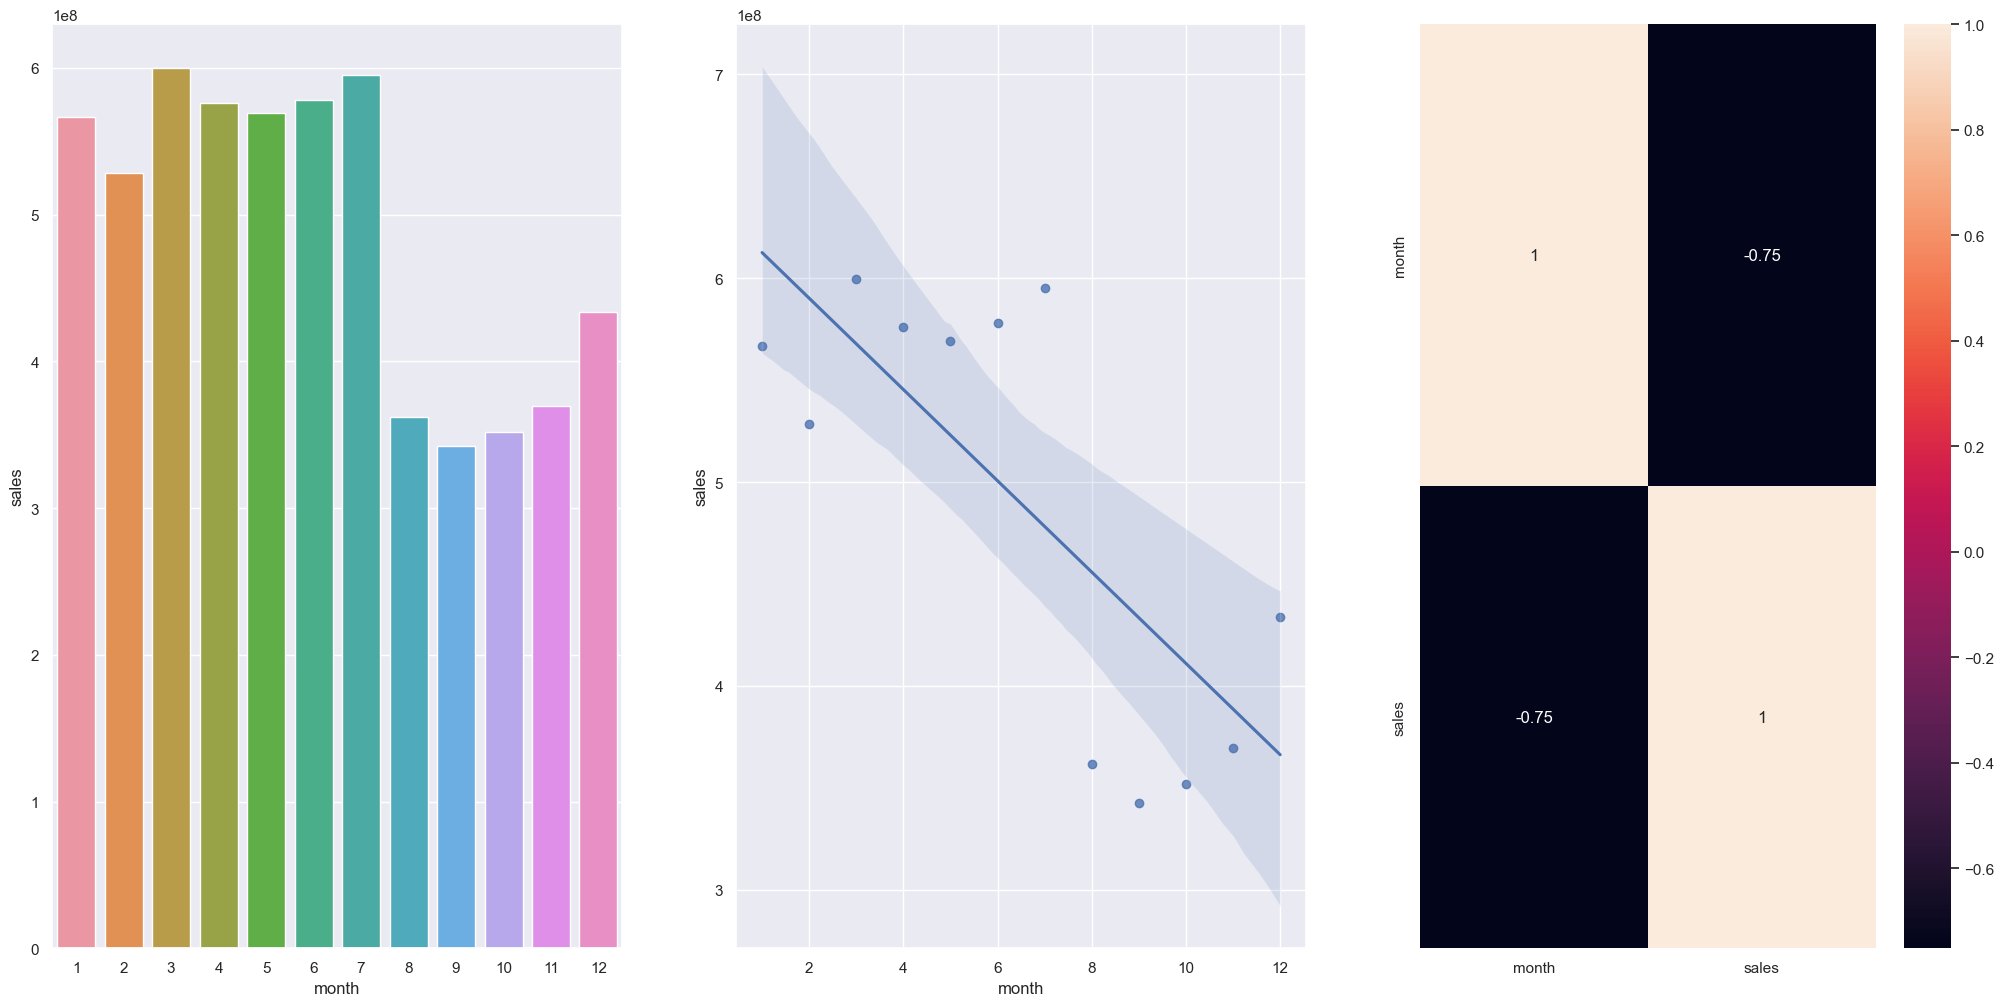

In [48]:
aux1 = df4[ [ 'month', 'sales' ] ].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(data = aux1, x = 'month', y = 'sales');

plt.subplot(1, 3, 2)
sns.regplot(data = aux1, x = 'month', y = 'sales');

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot = True);

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mês.

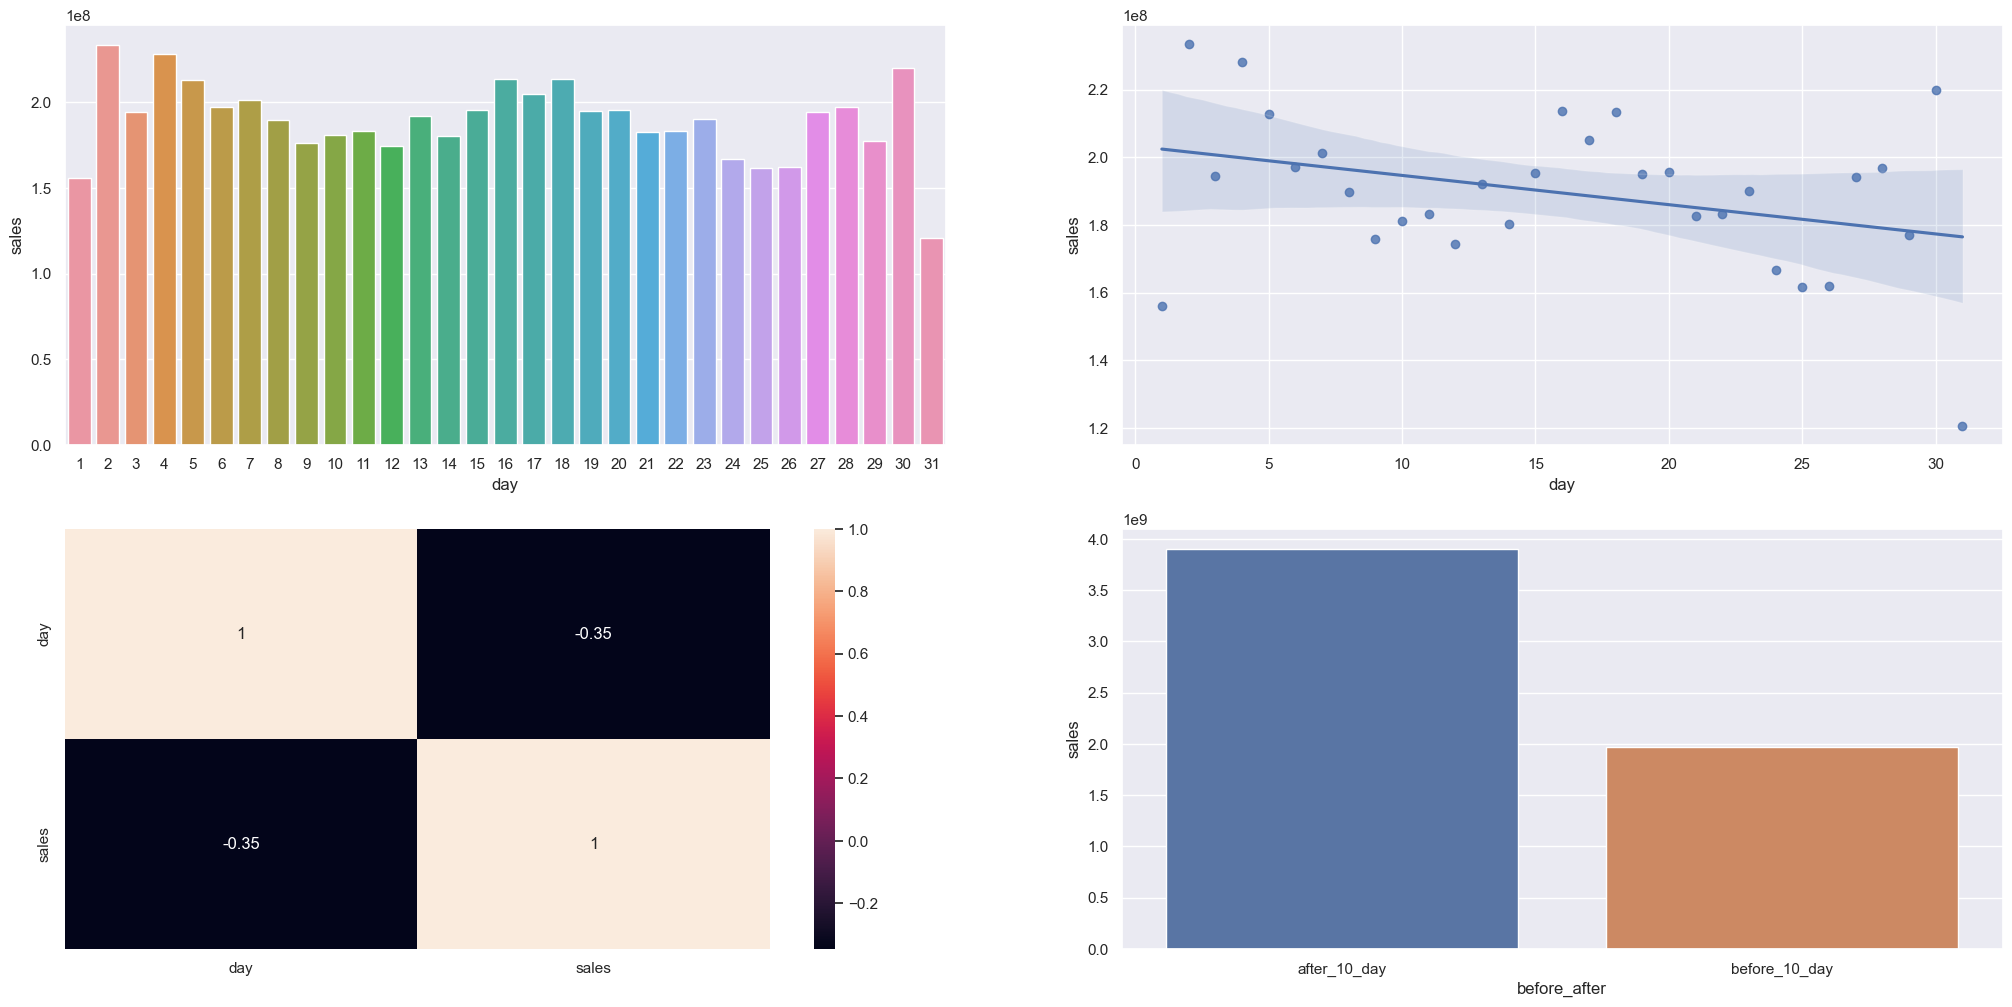

In [49]:
aux1 = df4[ [ 'day', 'sales' ] ].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(data = aux1, x = 'day', y = 'sales');

plt.subplot(2, 2, 2)
sns.regplot(data = aux1, x = 'day', y = 'sales');

plt.subplot(2, 2, 3)
sns.heatmap( aux1.corr( method='pearson'), annot = True);

aux1['before_after'] = aux1[ 'day' ].apply( lambda x: 'before_10_day' if x <= 10 else 'after_10_day')
aux2 = aux1[ [ 'before_after', 'sales' ] ].groupby('before_after').sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot(data = aux2, x = 'before_after', y = 'sales');

### **H11.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem menos nos final de semana.

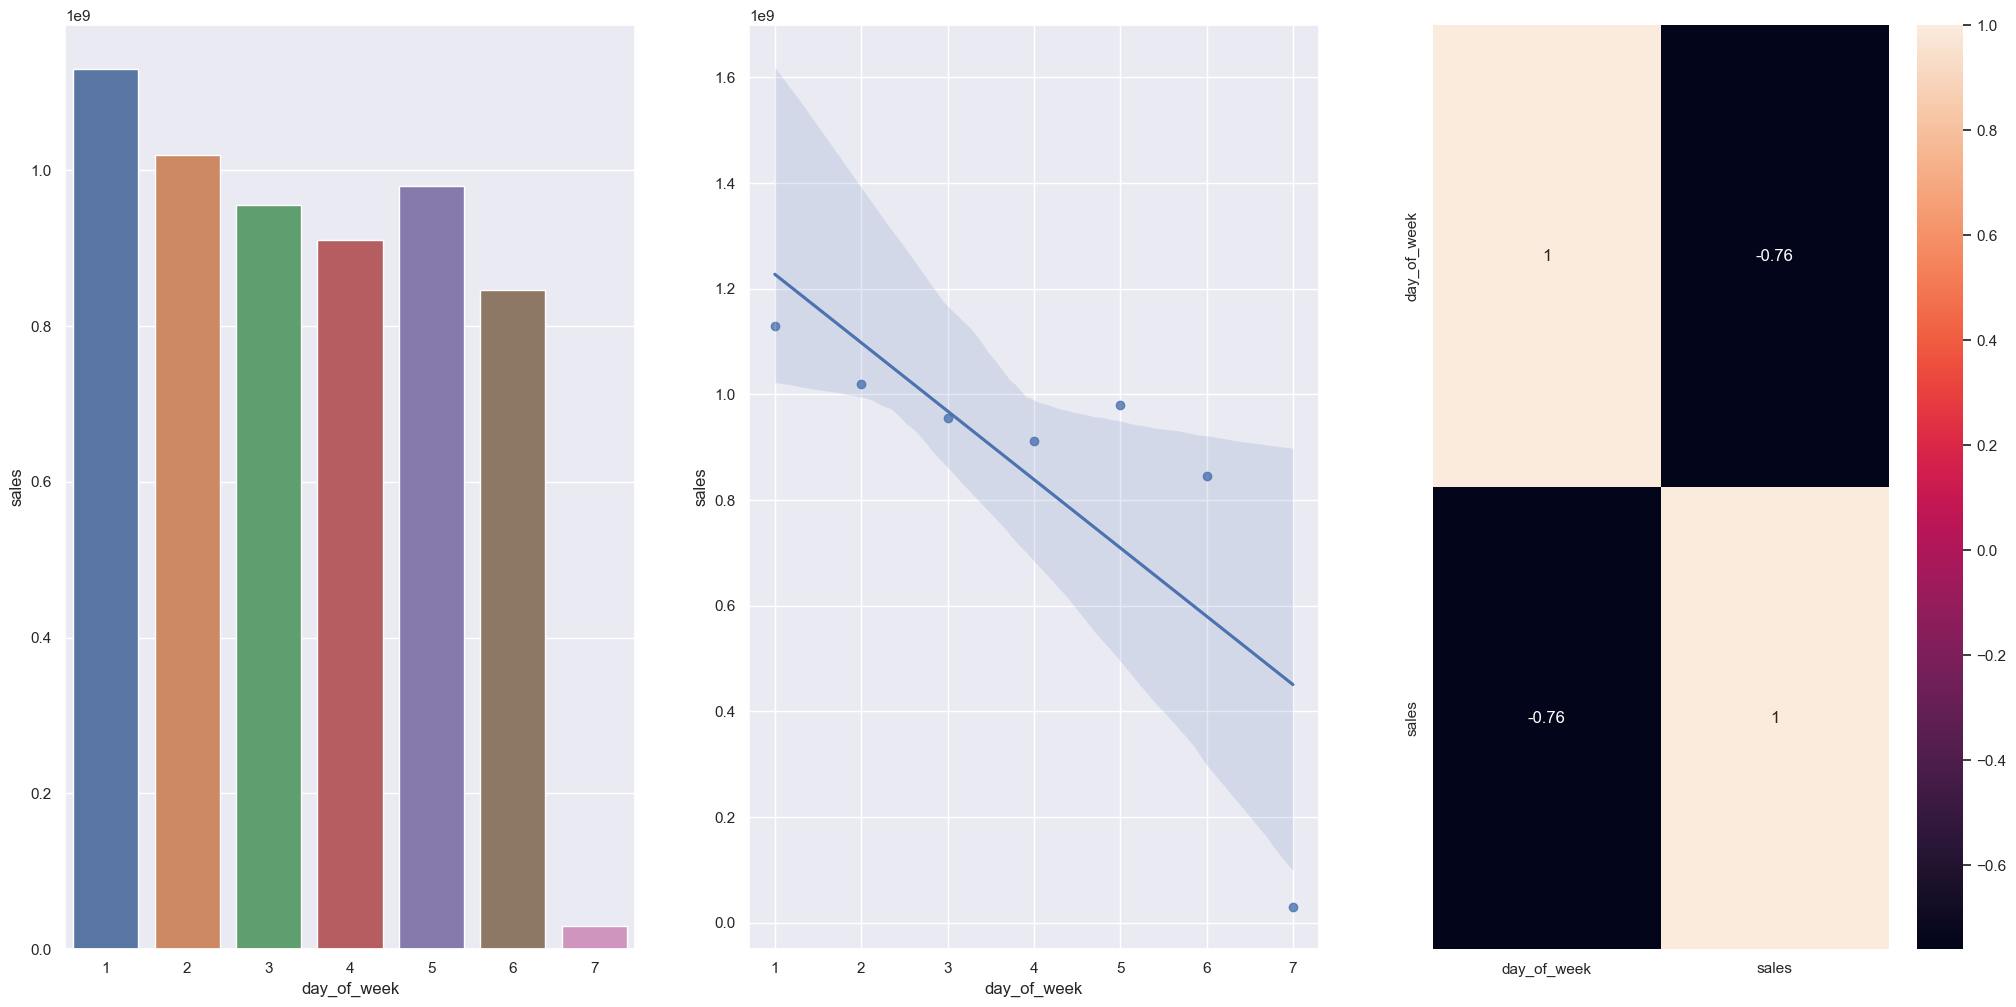

In [50]:
aux1 = df4[ [ 'day_of_week', 'sales' ] ].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(data = aux1, x = 'day_of_week', y = 'sales');

plt.subplot(1, 3, 2)
sns.regplot(data = aux1, x = 'day_of_week', y = 'sales');

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot = True);

### **H12.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem MENOS durante os feriados escolares, exceto os meses de Julho e Agosto.

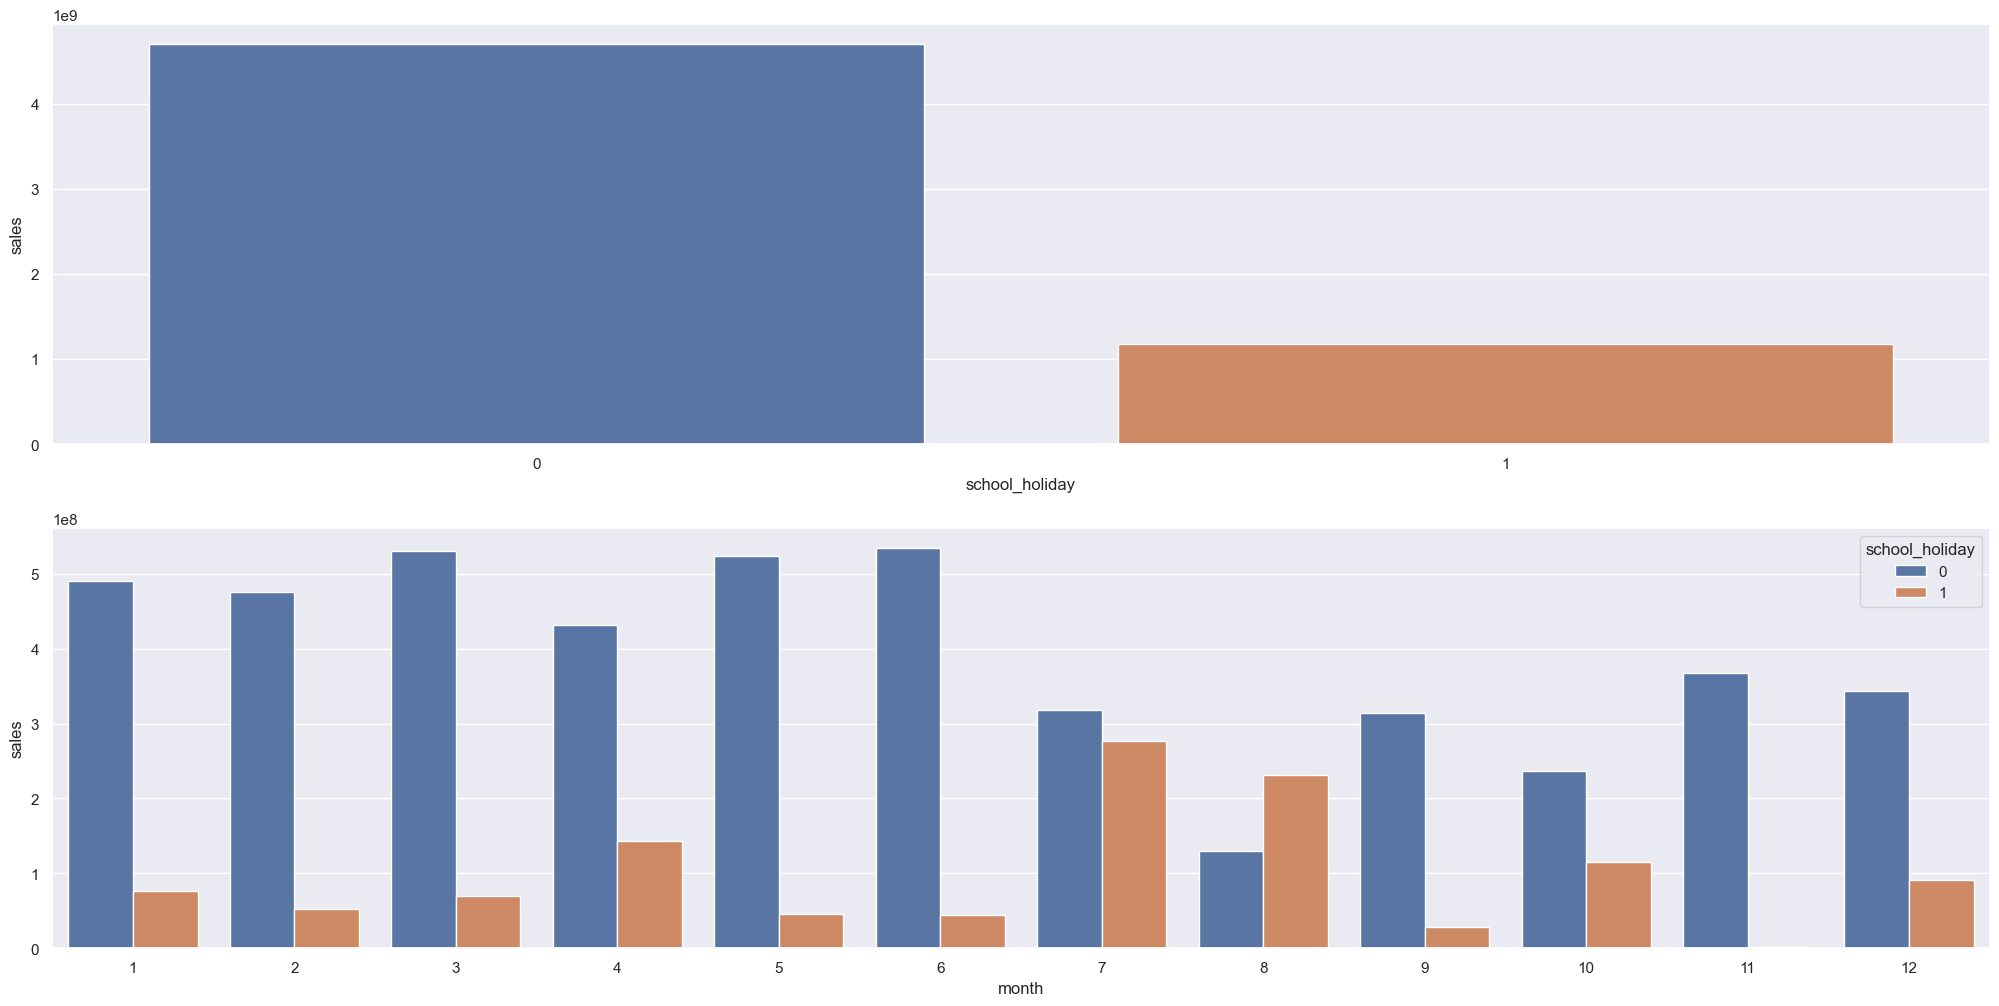

In [51]:
plt.subplot(2, 1, 1)
aux1 = df4[ ['school_holiday', 'sales'] ].groupby('school_holiday').sum().reset_index()
sns.barplot( data = aux1, x = 'school_holiday', y = 'sales');

plt.subplot(2, 1, 2)
aux2 = df4[ ['month', 'school_holiday', 'sales'] ].groupby( [ 'month', 'school_holiday' ] ).sum().reset_index()
sns.barplot( data = aux2, x = 'month', y = 'sales', hue = 'school_holiday');

### 4.2.1 -Resumo das Hipóteses

In [74]:
from tabulate import tabulate

In [53]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],
      ['H2', 'Falsa', 'Media'],
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Baixa'],
      ['H7', 'Falsa', 'Media'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Verdadeira', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Baixa'],
     ]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 - Análise Multivariada

### 4.3.1 Numerical Attributes

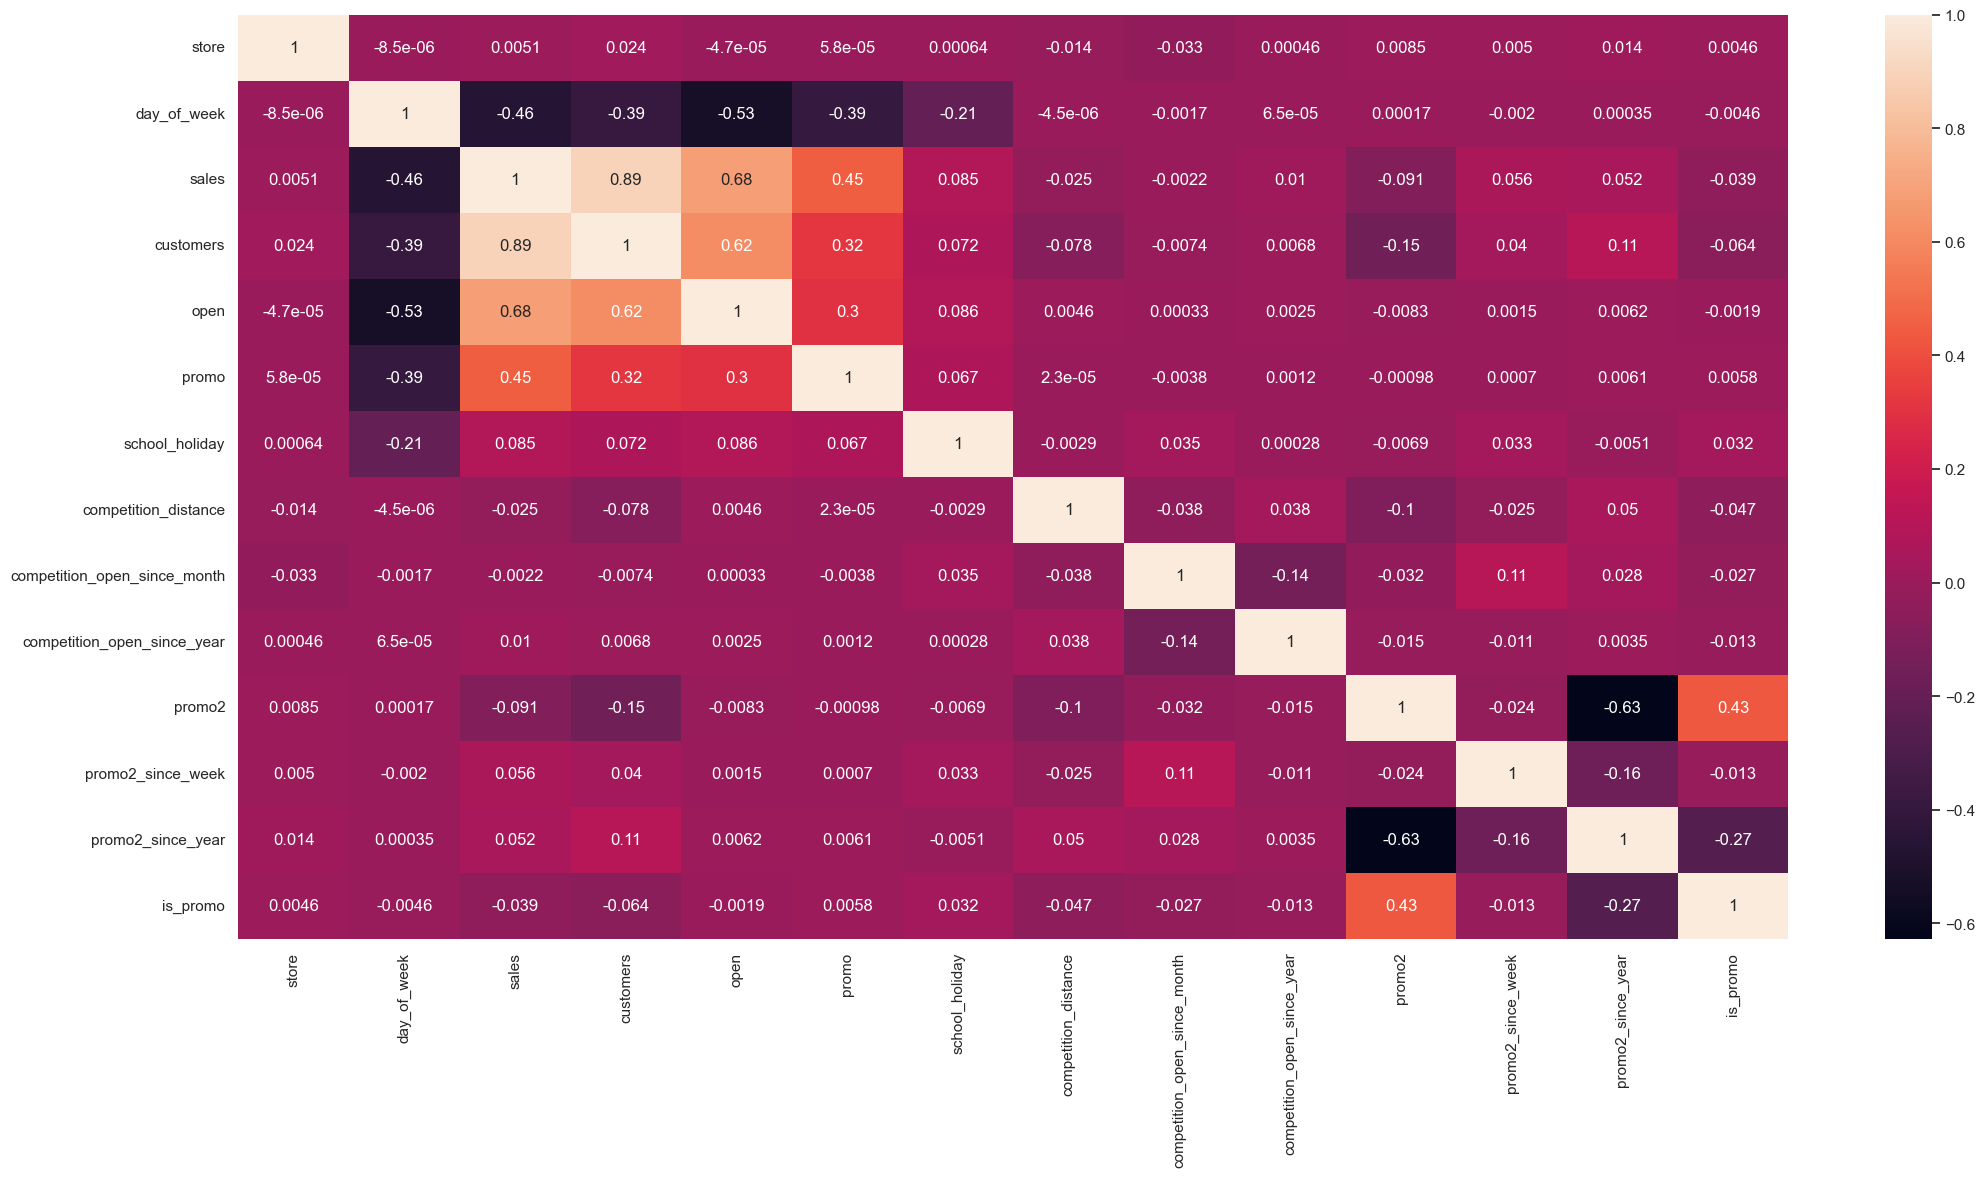

In [75]:
correlation = num_attributes.corr( method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical Attributes

In [76]:
# Only categorical data
a = df4.select_dtypes( include = [ 'object' ] )

# Calculate Cramer V
a1 = cramer_v( a[ 'state_holiday' ], a[ 'state_holiday' ] )
a2 = cramer_v( a[ 'state_holiday' ], a[ 'store_type' ] )
a3 = cramer_v( a[ 'state_holiday' ], a[ 'assortment' ] )

a4 = cramer_v( a[ 'store_type' ], a[ 'state_holiday' ] )
a5 = cramer_v( a[ 'store_type' ], a[ 'store_type' ] )
a6 = cramer_v( a[ 'store_type' ], a[ 'assortment' ] )

a7 = cramer_v( a[ 'assortment' ], a[ 'state_holiday' ] )
a8 = cramer_v( a[ 'assortment' ], a[ 'store_type' ] )
a9 = cramer_v( a[ 'assortment' ], a[ 'assortment' ] )

# Final dateset
d = pd.DataFrame({'state_holiday' : [a1, a2, a3],
              'store_type' : [a4, a5, a6],
              'assortment' : [a7, a8, a9] })
d = d.set_index( d.columns )

<Axes: >

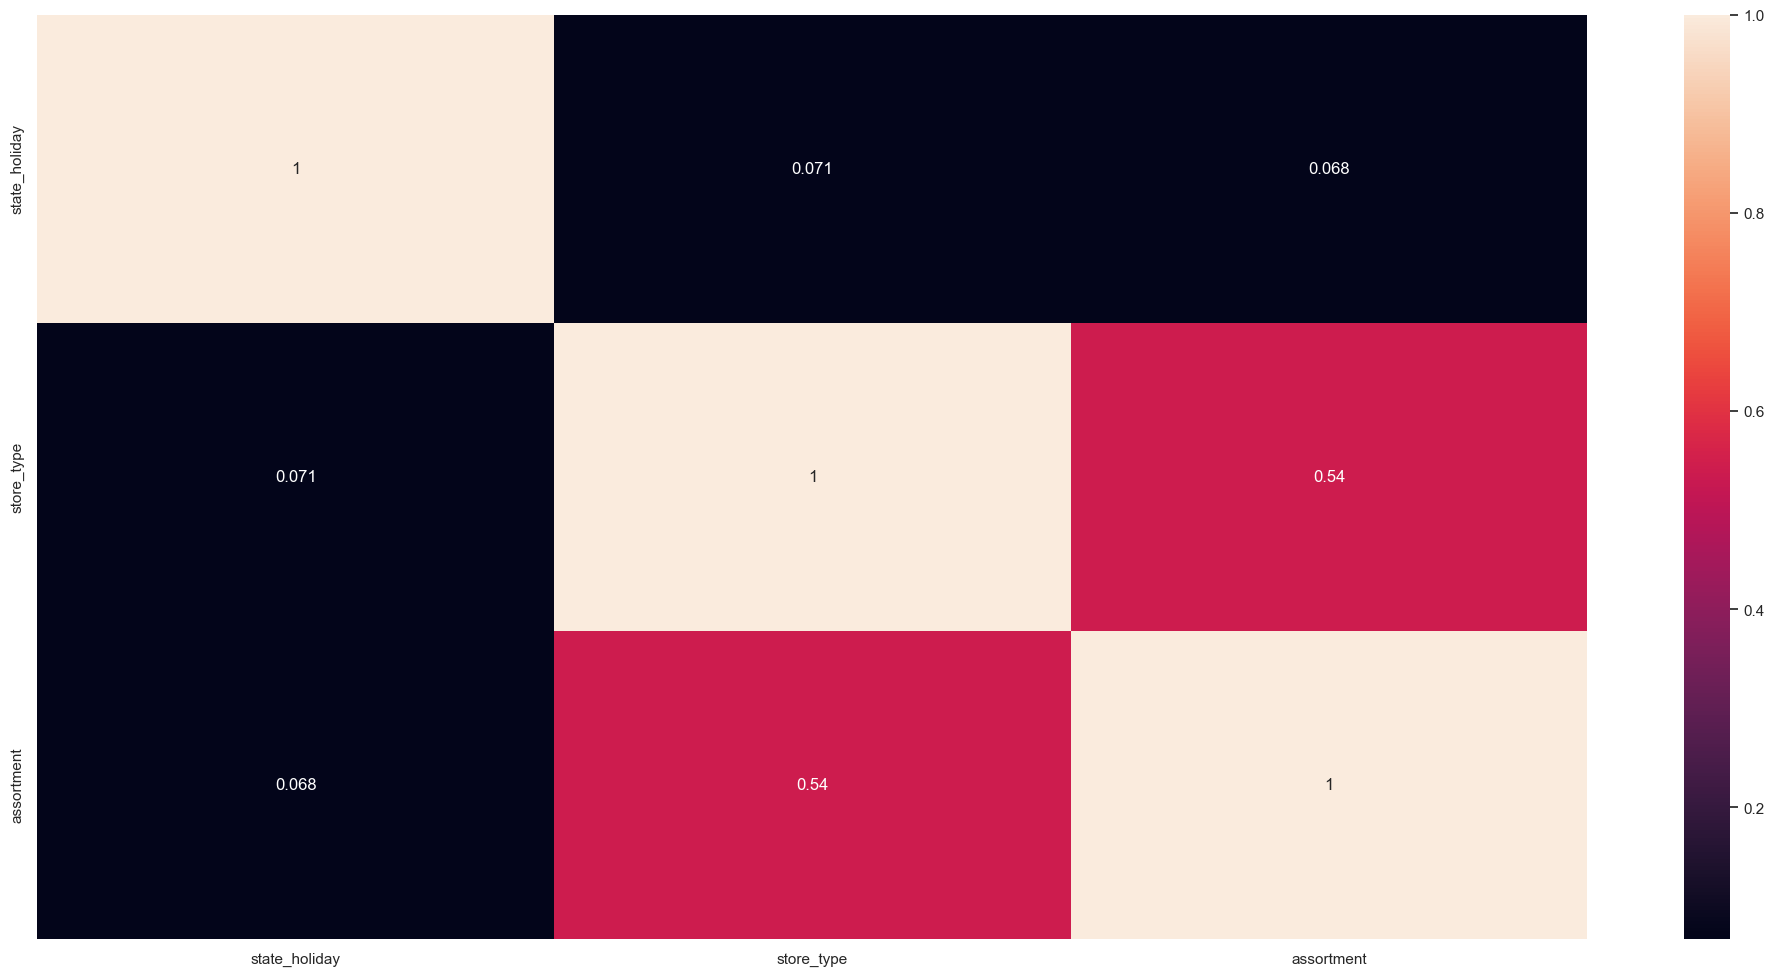

In [77]:
sns.heatmap( d, annot = True )

# 5.0 PASSO 05 - DATA PREPARATION

In [78]:
df5 = df4.copy()

## 5.1 - Normalização

## 5.2 - Rescaling

In [79]:
a = df5.select_dtypes(include=['int64', 'float64'])

In [80]:
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,4,0


**Verificando se tem outlines**

<Axes: >

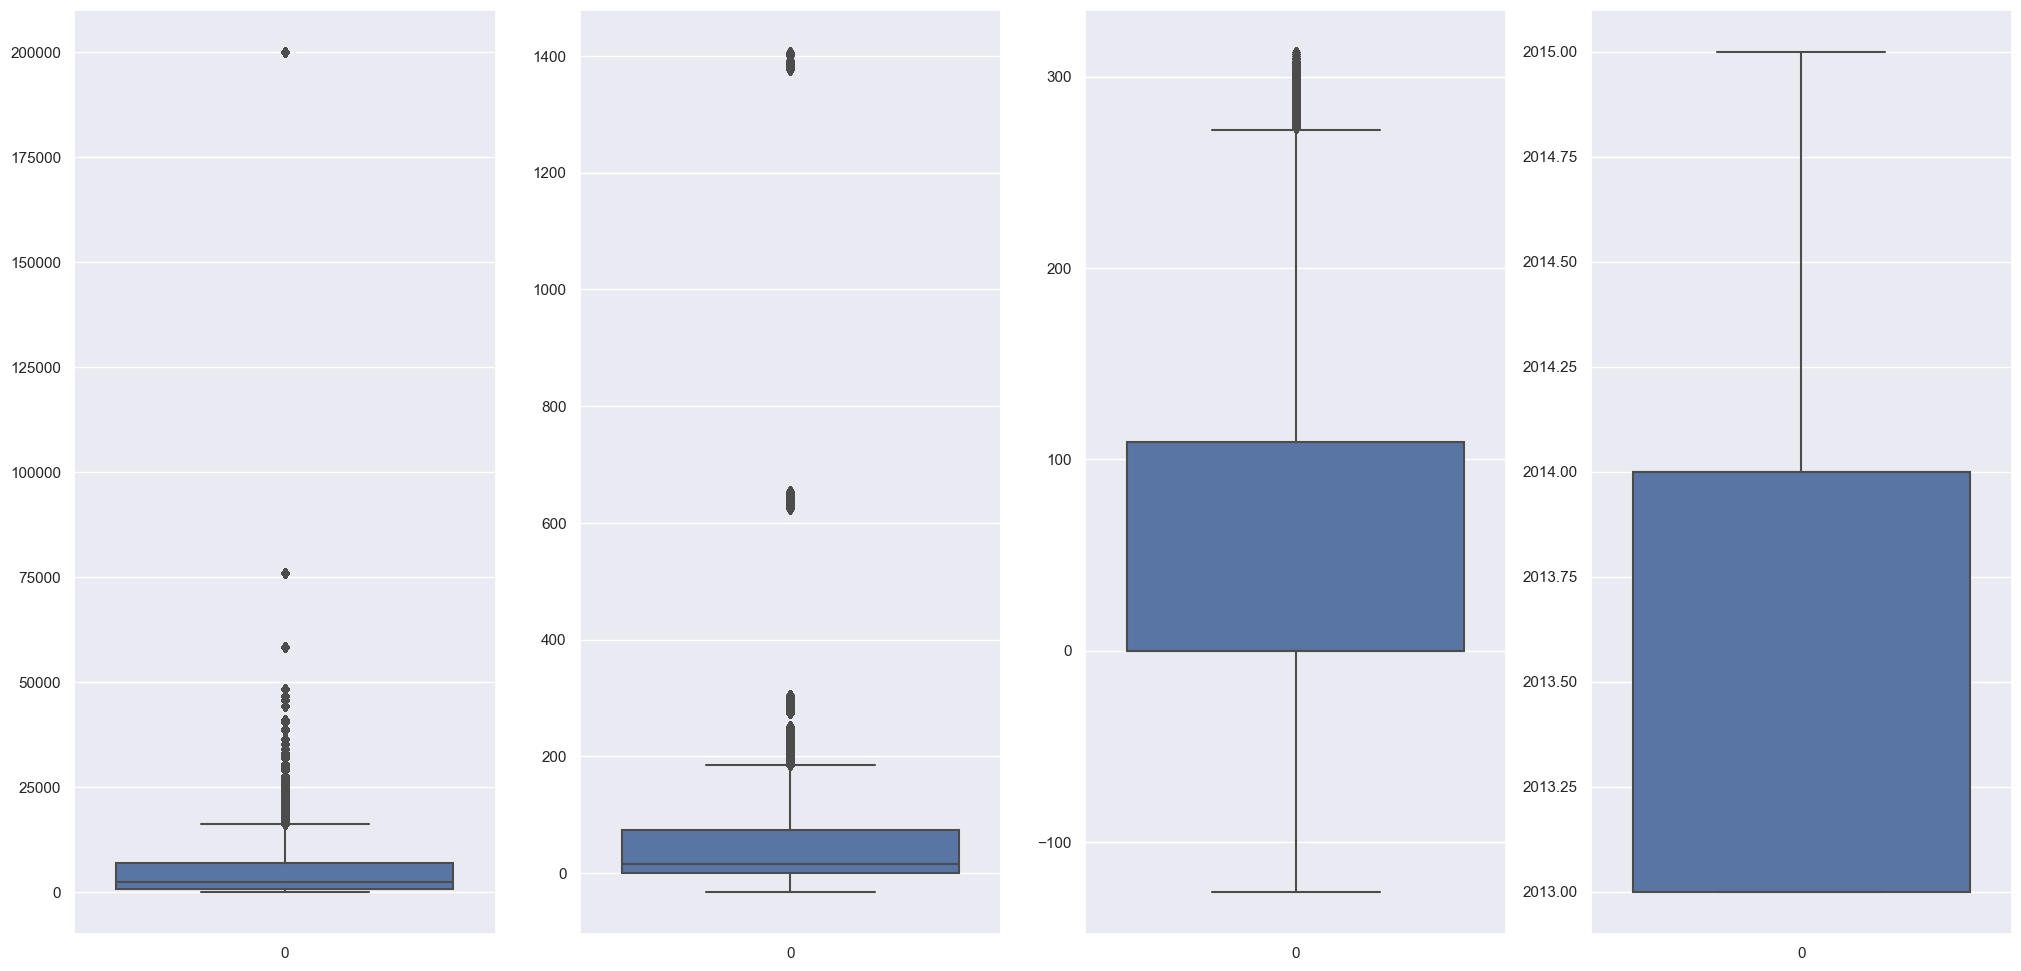

In [81]:
plt.subplot(1, 4, 1)
sns.boxplot(df5['competition_distance'])
plt.subplot(1, 4, 2)
sns.boxplot(df5['competition_time_month'])
plt.subplot(1, 4, 3)
sns.boxplot(df5['promo_time_week'])
plt.subplot(1, 4, 4)
sns.boxplot(df5['year'])

In [82]:
df5[['competition_distance', 'competition_time_month', 'promo_time_week']].sample(5)

,competition_distance,competition_time_month,promo_time_week
580571,500.0,0,221
703781,1130.0,60,0
173208,130.0,0,204
849096,22330.0,1,174
406005,520.0,65,0


**competition_distance e competition_time_month possuem outlines e portanto será aplicado Robust Scaler. Apesar de promo_time_week também possuir outlines, eles não são tão relevantes e por isso será aplicado o Min Max Scaler.**

In [83]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values ) # encontra os parâmetros da fórmula, quartil 1 e quartil 3, e aplica nos dados.

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values ) # encontra os parâmetros da fórmula, quartil 1 e quartil 3, e aplica nos dados.

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )

In [84]:
df5[['competition_distance', 'competition_time_month', 'promo_time_week']].sample(5)

,competition_distance,competition_time_month,promo_time_week
288740,-0.170968,0.797297,0.287016
759813,-0.217742,-0.364865,0.205011
670870,-0.335484,-0.216216,0.287016
47168,-0.008065,-0.216216,0.558087
861083,0.466129,0.445946,0.287016


## 5.3 - Transformação

### 5.3.1 Encoding

Variáveis categóricas

In [85]:
# state_holiday - One Hot Encoding
# state_holiday é um estado, ou é feriado ou não é feriado,
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

# store_type - Label Encoder
# Como store_type não possui uma ordem
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

# assortment possui ordem, basic < extra < extended
# assortment - Ordinal Enconding
assortment_dict = { 'basic': 1, 'extra': 2, 'extended': 3 }
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2 Response Variable Transformation

In [86]:
df5['sales'] = np.log1p(df5['sales'])

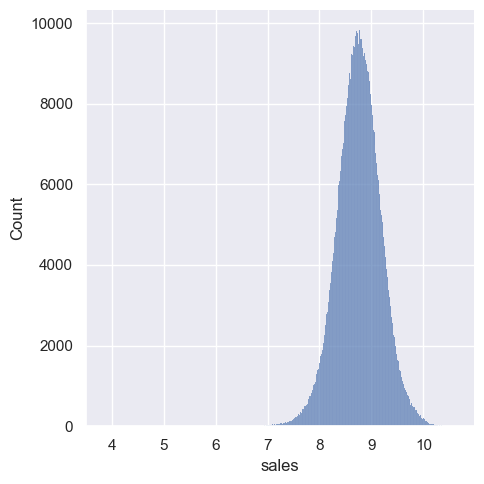

In [87]:
sns.displot(df5['sales']);

### 5.3.3 Transformação de natureza

Variáveis que possuiem natureza cíclica

**Transformação de Natureza Ciclica**

In [88]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi / 7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi / 7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi / 12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi / 12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi / 30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi / 30 ) ) )

# week_o£_vear
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi / 52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi / 52 ) ) )


In [89]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,False,False,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,False,False,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,False,False,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,False,False,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,False,False,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0. PASSO 06 - FEATURE SELECTION

In [90]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [91]:
cols_drop = [ 'week_of_year', 
             'day',
             'month', 
             'day_of_week', 
             'promo_since', 
             'competition_since', 
             'year_week' ]
df6 = df6.drop( cols_drop, axis = 1 )

In [92]:
# Verificando a data mínima, data de início das vendas, de cada loja.
df6[['store', 'date']].groupby('store').min().reset_index().head()

,store,date
0,1,2013-01-02
1,2,2013-01-02
2,3,2013-01-02
3,4,2013-01-02
4,5,2013-01-02


In [93]:
# Verificando a data maxíma, data de início das vendas, de cada loja.
df6[['store', 'date']].groupby('store').max().reset_index().head()

,store,date
0,1,2015-07-31
1,2,2015-07-31
2,3,2015-07-31
3,4,2015-07-31
4,5,2015-07-31


In [94]:
# Verificando o date equivalente a 6 semanas antes da última data de vendas.
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days = 7 * 6 )

Timestamp('2015-06-19 00:00:00')

In [95]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']

In [96]:
# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_test['sales']
Y_test.head()

0    8.568646
1    8.710290
2    9.025816
3    9.546527
4    8.481151
Name: sales, dtype: float64

In [97]:
print( 'Training Min Date: {}'.format( X_train[ 'date' ].min() ))
print( 'Training Max Date: {}'.format( X_train[ 'date' ].max() ))

print( '\nTesting Min Date: {}'.format( X_test[ 'date' ].min() ))
print( 'Testing Max Date: {}'.format( X_test[ 'date' ].max() ))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Testing Min Date: 2015-06-19 00:00:00
Testing Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [98]:
# training and test dataset for Boruta
X_train_n = X_train.drop(['date', 'sales'], axis = 1).values
Y_train_n = Y_train.values.ravel() # ravel() coloca tudo dentro de um vetor

In [99]:
# Define RandomForestRegressor
# n_jobs = -1 usa todos os Cores da máquina, fazendo todo o processamento em paralelo, ou seja, cria todas as árvores em paralelo e rode mais rápido.
rf = RandomForestRegressor( n_jobs = -1)

# Define Boruta
boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42)
boruta.fit(X_train_n, Y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy(estimator=RandomForestRegressor(n_estimators=73, n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x13B920040),
         n_estimators='auto', random_state=RandomState(MT19937) at 0x13B920040,
         verbose=2)

### 6.2.1. Best Features from Boruta

In [100]:
cols_selected = boruta.support_.tolist()

# best featuers
X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )


In [101]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [102]:
cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

## 6.3. Manual Feature Selection

In [117]:
cols_selected_boruta = [ 
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos' ]

# columns to add
feat_to_add = [ 'date', 'sales' ]

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

In [104]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# 7.0. PASSO 07 - MACHINE LEARNING MODELLING

In [105]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

In [106]:
aux1 = x_test.copy()
aux1['sales'] = Y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename( columns = { 'sales' : 'predictions' } )
aux1 = pd.merge(aux1, aux2, how='left', on='store') # on='store' -> anexa o conjunto de dados baseado no código da loja
yhat_baseline = aux1['predictions']

# performance
# ml_error() -> calcula a performance para nós, não precisa calcular a performance para cada modelo
# np.expm1 -> aplica exponencial na variável sales, pois ela sofreu transformação para log na sessão 5.3.2
baseline_result = ml_error( 'Average Model', np.expm1( Y_test ), np.expm1( yhat_baseline ) )

In [107]:
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [108]:
# model
lr = LinearRegression().fit( x_train, Y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( Y_test ), np.expm1( yhat_lr ) )

In [109]:
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


Observe que o valor de RMSE do modelo LinearRegression é maior que o RMSE do Average Model, isso indica que os dados tem um comportamento complexo e não lineares, e nesse caso um modelo linear não seria indicado, pois seu erro é maior que o erro de média. Modelos lineares não conseguirão aprender o comportamento desses dados.

### 7.2.1. Linear Regression Model - Cross Validation

In [185]:
lr_result_cv =cross_validation( x_training, 5, 'Linear Regression', lr )
lr_result_cv

,Model name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularized Model - LASSO

In [110]:
# model
lrr = Lasso( alpha = 0.01 ).fit( x_train, Y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( Y_test ), np.expm1( yhat_lrr ) )

In [187]:
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1. Lasso - Cross Validation

In [186]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr )
lrr_result_cv

,Model name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. Random Forest Regressor

In [111]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, Y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( Y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.115257,0.099842,1010.322344


### 7.4.1. Random Forest Regressor - Cross Validation

In [188]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv

KFold Number: 5
KFold Number: 4
KFold Number: 3
KFold Number: 2
KFold Number: 1


,Model name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.89 +/- 217.42,0.12 +/- 0.02,1254.75 +/- 316.61


## 7.5. XGBoost Regressor

In [112]:
# model
# objective -> função objetiva, para o problema de regressão usaremos o reg:squarederror
# eta -> quantas passadas é usada para fazer o aprendizado
# max_depth -> máxima profundidade de ramificações que a árvore pode chegar
# subsample -> quantidade de amostras ou porcentagem de todas as variáveis disponíveis para fazer uma amostragem para selecionar as mais relevantesq1w2e3r4
model_xgb = XGBRegressor( objective='reg:squarederror',
                          n_estimators=100,
                          eta=0.1,
                          max_depth=10,
                          subsample=0.7,
                          colsample_bytee=0.9 ).fit( x_train, Y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( Y_test ), np.expm1( yhat_xgb ) )
xgb_result

[14:15:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.



,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,850.10931,0.12466,1246.400646


### 7.5.1. XGBoost Regressor - Cross Validation

In [192]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv

KFold Number: 5
[19:27:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.

KFold Number: 4
[19:28:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.

KFold Number: 3
[19:29:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.

KFold Number: 2
[19:30:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.

KFold Number: 1
[19:31:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample

,Model name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1032.65 +/- 186.3,0.14 +/- 0.02,1485.11 +/- 255.55


## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [113]:
modelling_result = pd.concat ( [ baseline_result, lr_result, lrr_result, rf_result, xgb_result ] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.115257,0.099842,1010.322344
0,XGBoost Regressor,850.109310,0.124660,1246.400646
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


O fenômeno que estamos querendo modelar não é um problema simples, por isso os modelos lineares não funcionam muito bem nesses casos.

### 7.6.2. Real Performance - Cross Validation

In [194]:
modelling_result_cv = pd.concat ( [ lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv ] )
modelling_result_cv.sort_values( 'RMSE CV' )

,Model name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.89 +/- 217.42,0.12 +/- 0.02,1254.75 +/- 316.61
0,XGBoost Regressor,1032.65 +/- 186.3,0.14 +/- 0.02,1485.11 +/- 255.55
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
